In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time
from scipy import stats
import matplotlib.gridspec as gridspec

if 'path' in locals(): os.chdir(path)
else: os.chdir("../../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/MFI_paper_June24/"
path_Figure_E = path_manustript + "Figure_E/"
from pyMFI import MFI
from pyMFI import MFI1D
from pyMFI import run_plumed

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.size": 22, "font.family": "serif", "font.serif": ["computer modern roman"]})
plt.rcParams.update({"font.size": 22})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

times = r"$\times$"
pwr_neg = r"$^{-1}$"

#Define grid and analytical function
x=np.linspace(-2,2,201)
y=1*x**8-50*np.exp(-(x-1)**2/0.1)-93*np.exp(-(x+0.5)**2/0.05)-103*np.exp(-(x+1.5)**2/0.07)-70*np.exp(-(x)**2/0.03)+50*np.exp(-(x-0.5)**2/0.03)
y = y - np.min(y)
dy = np.gradient(y,x)


The path is: /home/ucecabj/Desktop/MFI_git


### Make modified function to save Force in fes_error_cutoff_evol

In [17]:
from numba import njit
@njit
def MFI_1D(HILLS, position, bw=0.1, kT=1, min_grid=-2, max_grid=2, nbins=201, 
           log_pace=-1, error_pace=-1, WellTempered=1, nhills=-1, periodic=0, 
           hp_centre=0.0, hp_kappa=0, lw_centre=0.0, lw_kappa=0, uw_centre=0.0, uw_kappa=0, F_static = np.zeros(1), 
           Ftot_den_limit = 1E-10, FES_cutoff = 0, Ftot_den_cutoff = 0, non_exploration_penalty = 0, save_intermediate_fes_error_cutoff = False, use_weighted_st_dev = True):
    
    """Compute a time-independent estimate of the Mean Thermodynamic Force, i.e. the free energy gradient in 1D CV spaces.

    Args:
        HILLS (array): HILLS array from HILLS file from metadynamics simulation using PLUMED. Contains number_of_hills * [time, position, metaD_width, metaD_height metaD_biasfactor].  
        position (str): CV/position array. Defaults to "position".
        bw (float, optional): bandwidth for the construction of the KDE estimate of the biased probability density. Defaults to 1.
        kT (float, optional): Boltzmann constant multiplied with temperature (reduced format, 120K -> 1).
        min_grid (float, optional): Lower bound of the force domain. Defaults to -2.
        max_grid (float, optional): Upper bound of the force domain. Defaults to 2.
        nbins (int, optional): number of bins in grid. Defaults to 101.
        log_pace (int, optional): Pace for outputting progress and convergence. Defaults to -1. When set to -1, progress will be outputted 5 times in total.
        error_pace (int, optional): Pace for calculating the on-the-fly error for  estimating global convergence. Defaults to -1. When set to -1, on-the-fly error will be calculated 50 times.
        WellTempered (binary, optional): Is the simulation well tempered?. Defaults to 1.
        nhills (binary, optional): Number of HILLS to be analysed. When set to -1, all HILLS will be analysed. Defaults to -1.
        periodic (binary, optional): Is the CV space periodic? 1 for yes. Defaults to 0.
        hp_centre (float, optional): position of harmonic potential. Defaults to 0.0.
        hp_kappa (flaot, optional): force_constant of harmonic potential. Defaults to 0.
        lw_centre (float, optional): position of lower wall potential. Defaults to 0.0.
        lw_kappa (flaot, optional): force_constant of lower wall potential. Defaults to 0.
        uw_centre (float, optional): position of upper wall potential. Defaults to 0.0.
        uw_kappa (flaot, optional): force_constant of upper wall potential. Defaults to 0.
        F_static (array, optional): Option to provide a starting bias potential that remains constant through the algorithm. This could be a harmonic potential, an previously used MetaD potential or any other bias potential defined on the grid. Defaults to np.zeros(1), which will automatically set F_static to a zero-array with length=nbins.
        Ftot_den_limit (float, optional): Probability density limit below which data will be set to zero (this is done for numerical stability reasons. For default Ftot_den_limit, numerical difference is negligable). Defaults to 1E-10.
        FES_cutoff (float, optional): Cutoff applied to FES and error calculation for FES values over the FES_cutoff. All FES values above the FES_cutoff won't contribuite towards the error. Useful when high FES values have no physical meaning. When FES_cutoff = 0, no cufoff is applied.Defaults to 0. 
        Ftot_den_cutoff (flaot, optional): Cutoff applied to FES and error calculation for Ftot_den (Probability density) values below the Ftot_den_cutoff. All FES values that are excluded by the cutoff won't contribuite towards the error. Useful when low Probability density values have little statistical significance or no physical meaning. When Ftot_den_cutoff = 0, no cufoff is applied. Defaults to 0.
        non_exploration_penalty (float, optional): Turns zero-value error to the non_exploration_penalty value. This should be used in combination with the cutoff. If some part of CV space hasn't been explored, or has a FES value that is irrelevanlty high, the cutoff will set the error of that region to zero. If the non_exploration_penalty is larger than zero, the error of that region will take the value of the non_exploration_penalty instead of zero. Default is set to 0.
        save_intermediate_fes_error_cutoff (bool, optional): If Ture, every time the error is calculated, the FES, variance, standard deviation and cutoff will be saved. Defaults to False.
        use_weighted_st_dev (bool, optional): When set to True, the calculated error will be the weighted standard deviation ( var^0.5 ). When set to False, the calculated error will be the standard error ( (var/n_sample)^0.5 ). Defaults to True. (The standard devaition is expected to converge after enough time, while the standard error is expected to decrease as more datapoints are added.)

    Returns:
        tuple: grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_evol, fes_error_cutoff_evol\n
        grid (array of size (nbins,)): CV-array.\n
        Ftot_den (array of size (nbins,)): Cumulative biased probability density.\n
        Ftot_den2 (array of size (nbins,): Cumulative (biased probability density squared). Used for error calculation.\n
        Ftot (array of size (nbins,)): Local Mean Force. When integrated will be the FES.\n
        ofv_num (array of size (nbins,)): Numerator of "on-the-fly" variance (ofv). Used for error calculation.\n
        FES (array of size (nbins,)): Free Energy Surface\n
        ofv (array of size (nbins,)): "on-the-fly" variance\n
        ofe (array of size (nbins,)): "on-the-fly" estimate of the standard deviation of the mean force\n
        cutoff (binary array of size (nbins,)): If FES_cutoff and/or Ftot_den_cutoff are specified, grid values outside the cufoff will be zero and grid values inside the cutoff will be one. If FES_cutoff and Ftot_den_cutoff not active, cutoff will be an array of ones.\n
        error_evol (array of size (4, total_number_of_hills//error_pace)): Evolution of error. First array is the collection of the global (average) "on-the-fly" variance, second array is the collection of the global (average) "on-the-fly" standard deviation, third array is the percentage of values within the specified cutoff, and the fourth array are the simulation times of the latter former arrays.\n
        fes_error_cutoff_evol (array of size (4, total_number_of_hills//error_pace, nbins)): First array is the collection of FES, second array is the collection of local "on-the-fly" variance, third array is the collection of local "on-the-fly" standard deviation, and the fourth is the collection of the cutoffs. The elements of the collections were calculated at the simulation times of the fourth array in error_evol.
        
        

    """
    for _i_ in [1]:
        #Specify grid
        grid = np.linspace(min_grid, max_grid, nbins)
        grid_space = (max_grid - min_grid) / (nbins-1)
        grid_ext = 0.25 * (max_grid-min_grid)
        
        #Specift constants
        stride = int(len(position) / len(HILLS[:, 1]))
        const = (1 / (bw * np.sqrt(2 * np.pi) * stride))
        bw2 = bw ** 2
        if nhills > 0: total_number_of_hills = nhills
        else: total_number_of_hills = len(HILLS)
        if log_pace < 0: log_pace = total_number_of_hills // 5
        if error_pace < 0: error_pace = total_number_of_hills // 50
        
        
        # initialise force terms
        Fbias = np.zeros(nbins)
        Ftot_num = np.zeros(nbins)
        Ftot_den = np.zeros(nbins)
        Ftot_den2 = np.zeros(nbins)
        ofv_num = np.zeros(nbins)
        
        #initialise other arrays and floats for intermediate results
        if total_number_of_hills % error_pace == 0: error_evol = np.zeros((4, total_number_of_hills // error_pace))
        else: error_evol = np.zeros((4, total_number_of_hills // error_pace +1))
        if save_intermediate_fes_error_cutoff == True: fes_error_cutoff_evol = np.zeros((4, len(error_evol[0]), nbins))
        else: fes_error_cutoff_evol = np.zeros((4, len(error_evol[0]), nbins))#np.zeros(1)
        error_count = 0
            
        #Calculate static force (form harmonic or wall potential)
        if len(F_static) != nbins: F_static = np.zeros(nbins)
        if hp_kappa > 0: F_static += MFI1D.find_hp_force(hp_centre, hp_kappa, grid, min_grid, max_grid, grid_space, periodic)
        if lw_kappa > 0: F_static += MFI1D.find_lw_force(lw_centre, lw_kappa, grid, min_grid, max_grid, grid_space, periodic)
        if uw_kappa > 0: F_static += MFI1D.find_uw_force(uw_centre, uw_kappa, grid, min_grid, max_grid, grid_space, periodic)


        # Definition Gamma Factor, allows to switch between WT and regular MetaD
        if WellTempered < 1: Gamma_Factor = 1
        else: Gamma_Factor = (HILLS[0, 4] - 1) / (HILLS[0, 4])
        
    #Cycle over windows of constant bias (for each deposition of a gaussian bias)
    for i in range(total_number_of_hills):
        
        #Get position data of window        
        s = HILLS[i, 1]  # centre position of Gaussian
        sigma_meta2 = HILLS[i, 2] ** 2  # width of Gaussian
        height_meta = HILLS[i, 3] * Gamma_Factor  # Height of Gaussian
        data = position[i * stride: (i + 1) * stride]  # positons of window of constant bias force.
        periodic_hills = MFI1D.find_periodic_point_numpy(np.array([s]), min_grid, max_grid, periodic, grid_ext)
        periodic_positions = MFI1D.find_periodic_point_numpy(data, min_grid, max_grid, periodic, grid_ext)
                
        # Find forces of window
        [pb_t, Fpbt, Fbias_window] = MFI1D.window_forces(periodic_positions, periodic_hills, grid, sigma_meta2, height_meta, kT, const, bw2, Ftot_den_limit)

        # update force terms
        Ftot_den += pb_t  # total probability density             
        Fbias += Fbias_window
        dfds = np.where(pb_t > Ftot_den_limit, Fpbt / pb_t, 0) + Fbias - F_static
        Ftot_num += np.multiply(pb_t, dfds)
        Ftot = np.where(Ftot_den > Ftot_den_limit, Ftot_num / Ftot_den, 0)

        # terms for error calculation
        Ftot_den2 += np.square(pb_t) 
        ofv_num += np.multiply(pb_t, np.square(dfds))  
  

        # Calculate error
        if (i + 1) % error_pace == 0 or (i+1) == total_number_of_hills:
            
            #If applicable, find FES and cutoff
            cutoff = np.ones(nbins, dtype=np.float64)
            if FES_cutoff > 0 or save_intermediate_fes_error_cutoff == True: FES = MFI1D.intg_1D(Ftot, grid_space)
            if FES_cutoff > 0: cutoff = np.where(FES < FES_cutoff, 1.0, 0)
            if Ftot_den_cutoff > 0: cutoff = np.where(Ftot_den > Ftot_den_cutoff, 1.0, 0)
            
                
            # calculate error
            ofv = np.where(Ftot_den > Ftot_den_limit, ofv_num / Ftot_den, 0) - np.square(Ftot)
            Ftot_den_sq = np.square(Ftot_den)
            Ftot_den_diff = Ftot_den_sq - Ftot_den2
            if use_weighted_st_dev == True: ofv *= np.where(Ftot_den_diff > 0, Ftot_den_sq / Ftot_den_diff, 0)
            else: ofv *= np.where(Ftot_den_diff > 0, Ftot_den2 / Ftot_den_diff, 0)
            ofv = np.multiply(ofv, cutoff)
            if non_exploration_penalty > 0: ofv = np.where(cutoff > 0.5, ofv, non_exploration_penalty**2) 
            ofe = np.where(ofv > 0, np.sqrt(ofv), 0)  

            #save global error evolution
            error_evol[0,error_count] = sum(ofv) / np.count_nonzero(ofv)
            error_evol[1,error_count] = sum(ofe) / np.count_nonzero(ofe)
            error_evol[2,error_count] = np.count_nonzero(cutoff) / nbins
            error_evol[3,error_count] = HILLS[i,0]
 
            # print(np.shape(FES), np.shape())
            
            # save local fes, error and cutoff
            if save_intermediate_fes_error_cutoff == True:
                fes_error_cutoff_evol[0,error_count] = FES
                fes_error_cutoff_evol[1,error_count] = Ftot
                fes_error_cutoff_evol[2,error_count] = ofe
                fes_error_cutoff_evol[3,error_count] = cutoff
            
            error_count += 1
            
            #window error             
                  
             
        if (i + 1) % log_pace == 0 or (i+1) == total_number_of_hills:
            print((round((i + 1) / total_number_of_hills * 100, 0)) , "%   OFE =", round(error_evol[1,error_count-1], 4))
                

    ofe = np.where(ofv != 0, np.sqrt(ofv), 0)
    FES = MFI1D.intg_1D(Ftot, grid_space)
    
    return grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_evol, fes_error_cutoff_evol


#### Plot Figure 4

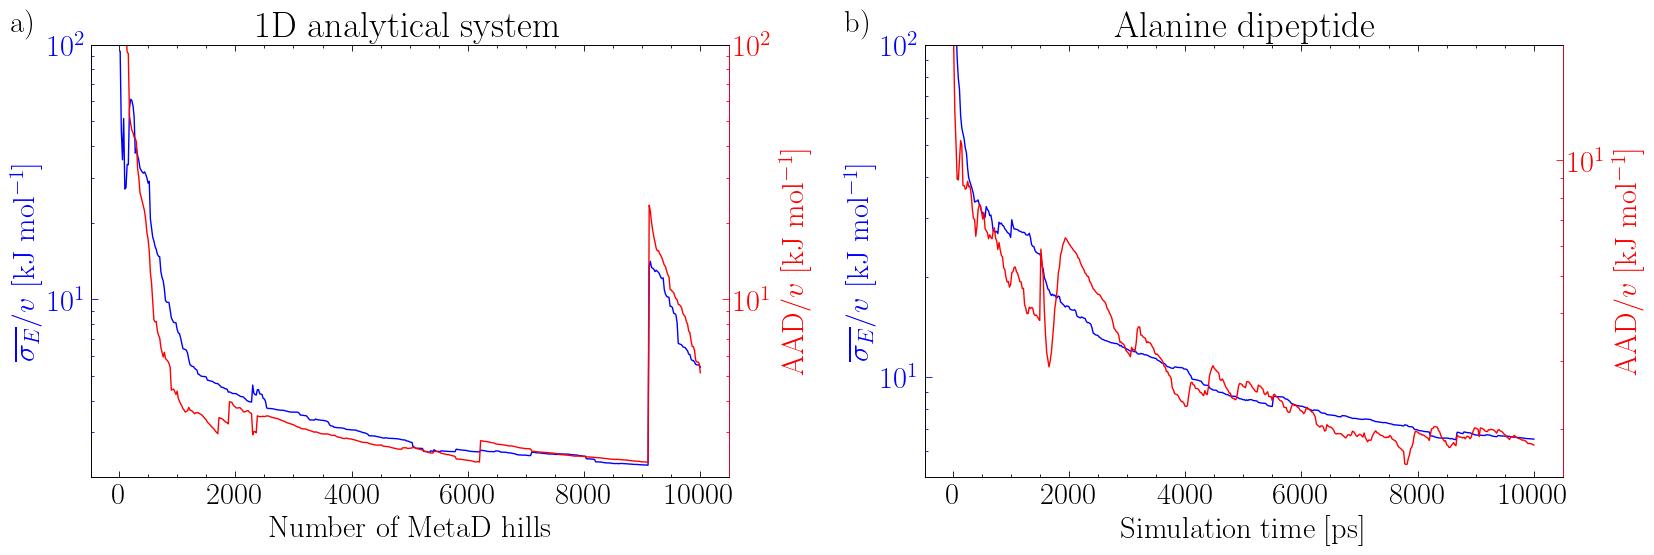

In [18]:
[time_history_1, ofe_history_1, aad_history_1 ,volume_history_1] = MFI.load_pkl(path_Figure_E + "data_figure_E_1A.pkl")
[time_history_2, ofe_history_2, aad_history_2 ,volume_history_2] = MFI.load_pkl(path_Figure_E + "data_figure_E_1B.pkl")

fig = plt.figure(figsize=(17,6))
gs = gridspec.GridSpec(3, 100, height_ratios=[1, 1, 1])

ax1 = fig.add_subplot(1,2,1)
ax2 = ax1.twinx()

ax4 = fig.add_subplot(1,2,2) 
ax5 = ax4.twinx() 

##############################################################################################################


ax1.plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1) ,color='blue',linewidth=1)
ax2.plot( time_history_1, np.asarray(aad_history_1) / np.asarray(volume_history_1) ,color='red',linewidth=1)
ax1.set_xlabel("Number of MetaD hills"); ax1.set_ylabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]", c="blue"); ax2.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 
ax1.set_ylim(0,30)
ax2.set_ylim(0,30)
# ax1.set_xlim(-750, 10200)
ax1.tick_params(axis='y', which='both', colors='blue'); ax1.spines['right'].set_color('blue')      
ax2.tick_params(axis='y', which='both', colors='red'); ax2.spines['right'].set_color('red')    
ax1.set_title("1D analytical system")
ax1.set_yscale("log")
ax1.set_ylim(2,100)
ax2.set_yscale("log")
ax2.set_ylim(2,100)
 

##############################################################################################################

ax4.plot( time_history_2, np.asarray(ofe_history_2) / np.asarray(volume_history_2) ,color='blue',linewidth=1,label="Aofe")
ax5.plot( time_history_2, np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,color='red',linewidth=1,label="AAD")
ax4.set_xlabel("Simulation time [ps]"); ax4.set_ylabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]", c="blue"); ax5.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")
ax4.set_ylim(0,50)
ax5.set_ylim(0,10)
# ax4.set_xlim(-750, 10200)
ax4.tick_params(axis='y', which='both', colors='blue'); ax4.spines['right'].set_color('blue')        
ax5.tick_params(axis='y', which='both', colors='red'); ax5.spines['right'].set_color('red')      
ax4.set_title("Alanine dipeptide")
ax4.set_yscale("log")
ax4.set_ylim(5,100)
ax5.set_yscale("log")
ax5.set_ylim(1.5,20)

h = [0.91]
w = [0.02, 0.51]
fig.text(x=w[0], y=h[0], s="a)")
fig.text(x=w[1], y=h[0], s="b)")


plt.tight_layout()
# plt.savefig(path_Figure_E + 'Figure4_MFI.png', dpi=600, bbox_inches='tight')
plt.show()

#### Investigate effect of changing bw

20.0 %   OFE = 4.7149
40.0 %   OFE = 4.1137
60.0 %   OFE = 3.5652
80.0 %   OFE = 3.457
100.0 %   OFE = 12.3557
20.0 %   OFE = 2.2453
40.0 %   OFE = 1.6781
60.0 %   OFE = 1.4145
80.0 %   OFE = 1.371
100.0 %   OFE = 4.7094
20.0 %   OFE = 1.5551
40.0 %   OFE = 1.1515
60.0 %   OFE = 1.0043
80.0 %   OFE = 0.9387
100.0 %   OFE = 1.5511


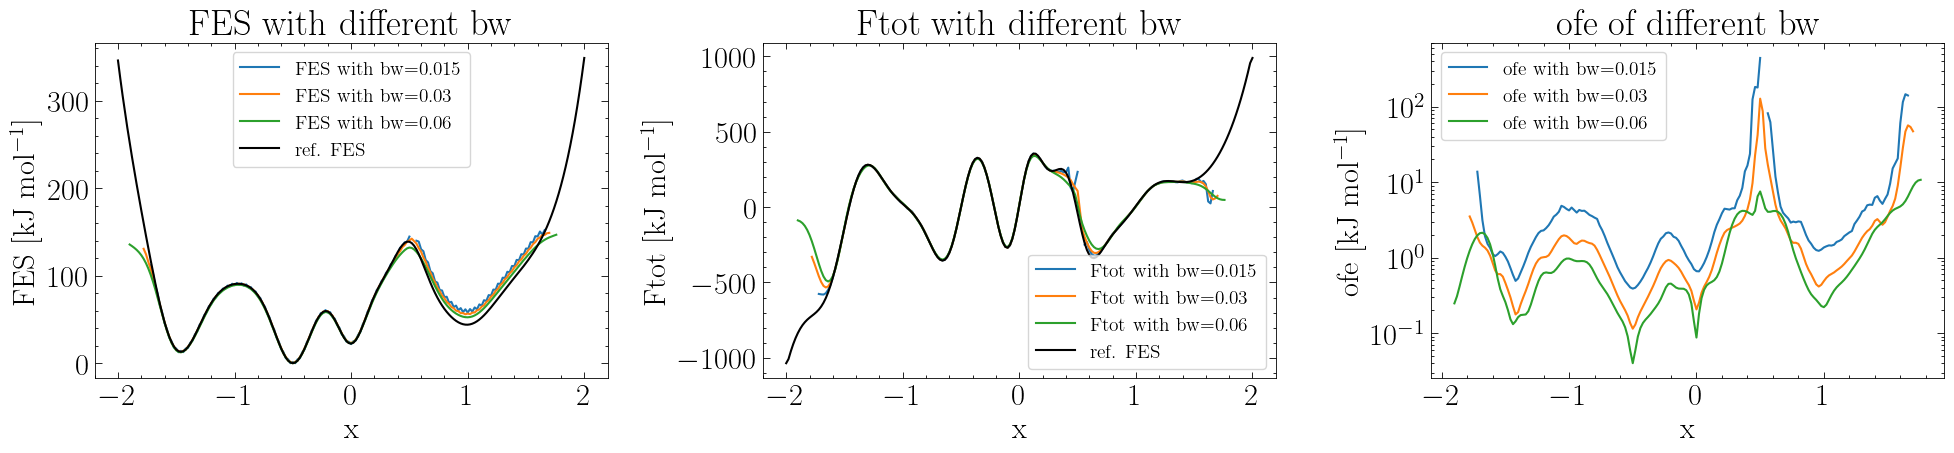

In [19]:
plt.figure(figsize=(20,5)); 
bw_list = [0.015, 0.03, 0.06]
bw_str_list = ["0.015", "0.03", "0.06"]
x=np.linspace(-2,2,201)
y=1*x**8-50*np.exp(-(x-1)**2/0.1)-93*np.exp(-(x+0.5)**2/0.05)-103*np.exp(-(x+1.5)**2/0.07)-70*np.exp(-(x)**2/0.03)+50*np.exp(-(x-0.5)**2/0.03)
y = y - np.min(y)
dy = np.gradient(y, x[1]-x[0])

for indx, bw in enumerate(bw_list):
    
    ###--- Analyse the data with MFI
	#Read the HILLS and Colvar data
	os.chdir(path_manustript + "Figure1A")
	HILLS=MFI1D.load_HILLS(hills_name="HILLS")
	position = MFI1D.load_position(position_name="position")

	#Compute the time-independent mean force and free energy surface
	reselts = MFI_1D(HILLS = HILLS, position = position, bw = bw, log_pace = 4000, error_pace = int(len(HILLS)/500), 
						FES_cutoff=-1, Ftot_den_cutoff=0.1, save_intermediate_fes_error_cutoff = True, use_weighted_st_dev=False)
	X, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_evol, fes_error_cutoff_evol = reselts

	aad_evol = []; aad_v_evol = []
	aad_force_evol = []; aad_force_v_evol = []
	for i in range(len(fes_error_cutoff_evol[0])):
		
		#Find FES and error
		FES = fes_error_cutoff_evol[0,i] 
		AD = abs(FES - y) * fes_error_cutoff_evol[3,i]
		AAD = np.sum(AD) / np.count_nonzero(AD)
		volume = np.count_nonzero(fes_error_cutoff_evol[3,i]) / len(fes_error_cutoff_evol[3,i])
		aad_evol.append(AAD)
		aad_v_evol.append(AAD / volume)
  
		Force = fes_error_cutoff_evol[1,i] 
		AD_force = abs(Force - dy) * fes_error_cutoff_evol[3,i]
		AAD_force = np.sum(AD_force) / np.count_nonzero(AD_force)
		aad_force_evol.append(AAD_force)
		aad_force_v_evol.append(AAD_force / volume)

	plt.subplot(1,3,1); plt.plot(x, np.where(fes_error_cutoff_evol[3,i] > 0.5, FES, np.nan), label="FES with bw=" + bw_str_list[indx])
	plt.subplot(1,3,2); plt.plot(x, np.where(fes_error_cutoff_evol[3,i] > 0.5, Ftot, np.nan), label="Ftot with bw=" + bw_str_list[indx])
	plt.subplot(1,3,3); plt.plot(x, np.where(fes_error_cutoff_evol[3,i] > 0.5, ofe, np.nan), label="ofe with bw=" + bw_str_list[indx])
			
	MFI.save_pkl([error_evol[3], error_evol[1], aad_evol, aad_force_evol, error_evol[2]], path_manustript +"Figure_E/data_figure_E_1A_bw" + bw_str_list[indx] + ".pkl")

plt.subplot(1,3,1); plt.plot(x, y, label="ref. FES", color="black"); plt.legend(fontsize=14); plt.title("FES with different bw"); plt.xlabel("x"); plt.ylabel("FES [kJ mol$^{-1}$]"); 

plt.subplot(1,3,2); plt.plot(x, dy, label="ref. FES", color="black"); plt.legend(fontsize=14); plt.title("Ftot with different bw"); plt.xlabel("x"); plt.ylabel("Ftot [kJ mol$^{-1}$]");

plt.subplot(1,3,3); plt.legend(fontsize=14); plt.title("ofe of different bw"); plt.xlabel("x"); plt.ylabel("ofe [kJ mol$^{-1}$]"); plt.yscale("log")
plt.tight_layout(); 
# plt.savefig(path_Figure_E + 'FigureE_FES_Force_ofe_with_multi_bw.png', dpi=600, bbox_inches='tight')
plt.show();

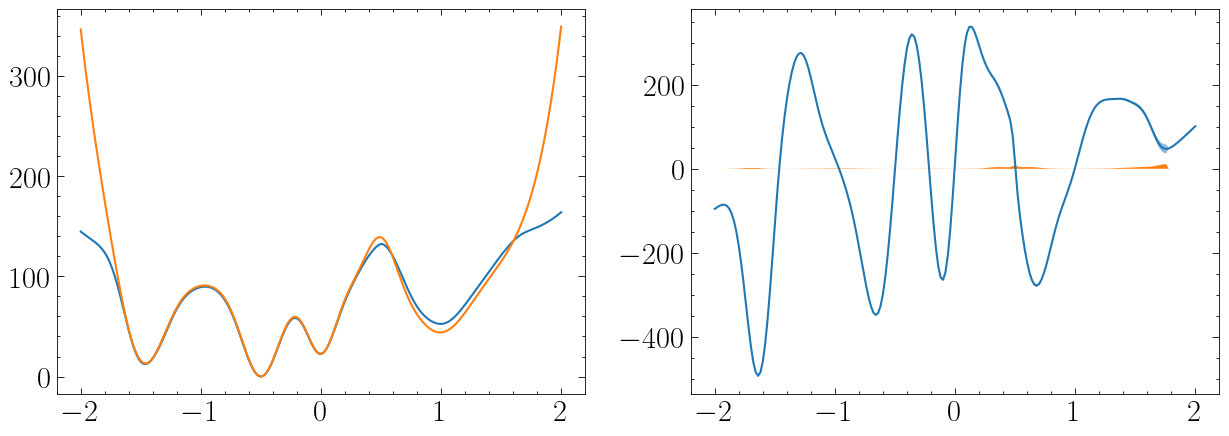

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x, FES)
plt.plot(x, y)

plt.subplot(1,2,2)
plt.plot(x, Ftot)
plt.fill_between(x, Ftot-ofe, Ftot+ofe, alpha=0.5)
plt.fill_between(x, np.zeros_like(x), ofe)

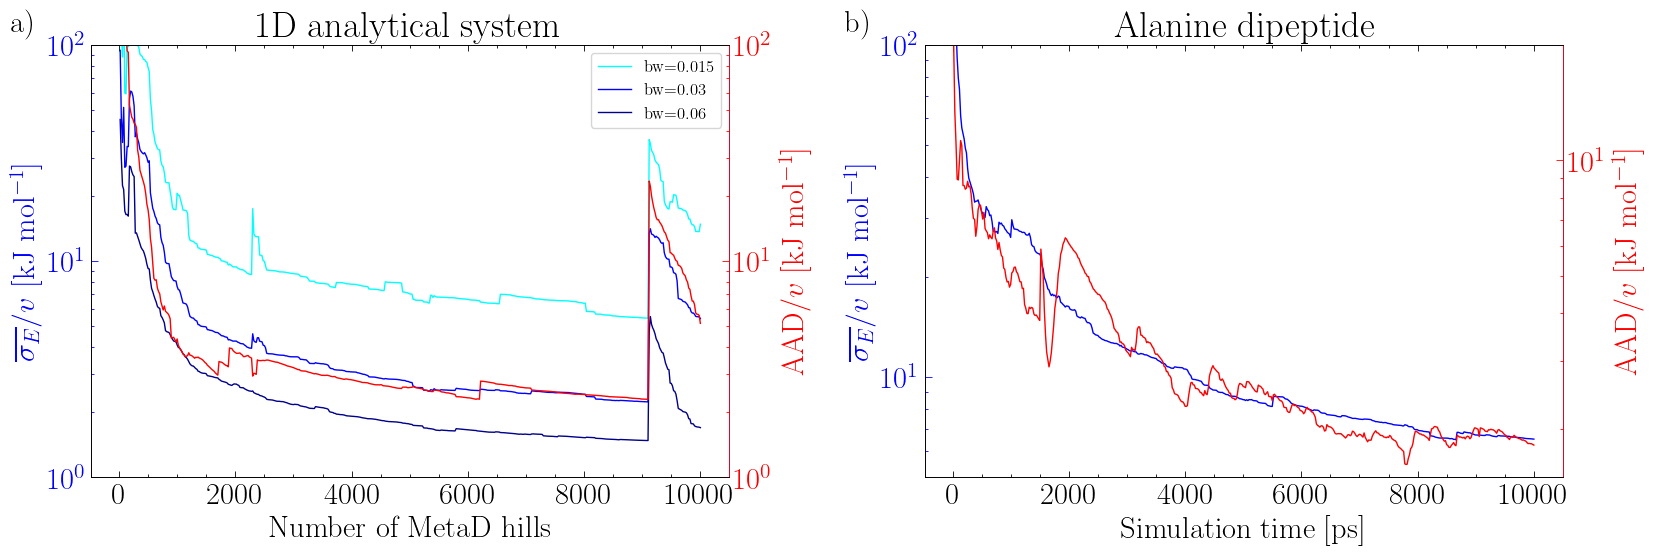

In [21]:
[time_history_1, ofe_history_1, aad_history_1 ,volume_history_1] = MFI.load_pkl(path_Figure_E + "data_figure_E_1A.pkl")

[time_history_11, ofe_history_11, aad_history_11, aad_force_history_11 ,volume_history_11] = MFI.load_pkl(path_Figure_E + "data_figure_E_1A_bw0015.pkl")
[time_history_12, ofe_history_12, aad_history_12, aad_force_history_12 ,volume_history_12] = MFI.load_pkl(path_Figure_E + "data_figure_E_1A_bw003.pkl")
[time_history_13, ofe_history_13, aad_history_13, aad_force_history_13 ,volume_history_13] = MFI.load_pkl(path_Figure_E + "data_figure_E_1A_bw006.pkl")

[time_history_2, ofe_history_2, aad_history_2 ,volume_history_2] = MFI.load_pkl(path_Figure_E + "data_figure_E_1B.pkl")

fig = plt.figure(figsize=(17,6))
gs = gridspec.GridSpec(3, 100, height_ratios=[1, 1, 1])

ax1 = fig.add_subplot(1,2,1)
ax2 = ax1.twinx()

ax4 = fig.add_subplot(1,2,2) 
ax5 = ax4.twinx() 

##############################################################################################################


# ax1.plot( time_history_11, np.asarray(ofe_history_11) / np.asarray(volume_history_11) ,color='cyan',linewidth=1, label="bw=0.015")

ax1.plot( time_history_11, np.asarray(ofe_history_11) / np.asarray(volume_history_11) ,color='cyan',linewidth=1    , label="bw=0.015")
ax1.plot( time_history_12, np.asarray(ofe_history_12) / np.asarray(volume_history_12) ,color='blue',linewidth=1    , label="bw=0.03")
ax1.plot( time_history_13, np.asarray(ofe_history_13) / np.asarray(volume_history_13) ,color='darkblue',linewidth=1, label="bw=0.06")
ax1.legend(fontsize=12)

ax2.plot( time_history_1, np.asarray(aad_history_1) / np.asarray(volume_history_1) ,color='red',linewidth=1)

# ax2.plot( time_history_11, np.asarray(aad_history_11) / np.asarray(volume_history_11) ,color='orange',linewidth=1   , label="bw=0.015")
# ax2.plot( time_history_12, np.asarray(aad_history_12) / np.asarray(volume_history_12) ,color='red',linewidth=1      , label="bw=0.03")
# ax2.plot( time_history_13, np.asarray(aad_history_13) / np.asarray(volume_history_13) ,color='firebrick',linewidth=1, label="bw=0.06")
# ax2.legend(fontsize=12, loc="upper center")

ax1.set_xlabel("Number of MetaD hills"); ax1.set_ylabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]", c="blue"); ax2.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 
ax1.tick_params(axis='y', which='both', colors='blue'); ax1.spines['right'].set_color('blue'); ax2.tick_params(axis='y', which='both', colors='red'); ax2.spines['right'].set_color('red'); ax1.set_title("1D analytical system")

ax1.set_yscale("log")
ax1.set_ylim(1,100)

ax2.set_yscale("log")
ax2.set_ylim(1,100)


##############################################################################################################

ax4.plot( time_history_2, np.asarray(ofe_history_2) / np.asarray(volume_history_2) ,color='blue',linewidth=1,label="Aofe")
ax5.plot( time_history_2, np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,color='red',linewidth=1,label="AAD")
ax4.set_xlabel("Simulation time [ps]"); ax4.set_ylabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]", c="blue"); ax5.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")
ax4.set_ylim(0,50)
ax5.set_ylim(0,10)
# ax4.set_xlim(-750, 10200)
ax4.tick_params(axis='y', which='both', colors='blue'); ax4.spines['right'].set_color('blue')        
ax5.tick_params(axis='y', which='both', colors='red'); ax5.spines['right'].set_color('red')      
ax4.set_title("Alanine dipeptide")
ax4.set_yscale("log")
ax4.set_ylim(5,100)
ax5.set_yscale("log")
ax5.set_ylim(1.5,20)

h = [0.91]
w = [0.02, 0.51]
fig.text(x=w[0], y=h[0], s="a)")
fig.text(x=w[1], y=h[0], s="b)")


plt.tight_layout()
plt.savefig(path_Figure_E + 'Figure4_MFI.png', dpi=600, bbox_inches='tight')
plt.show()

# ##############################################################################################################
# fig = plt.figure(figsize=(10,7))
# ax1 = fig.add_subplot(1,1,1)
# ax2 = ax1.twinx()

# # ax1.plot( time_history_11, np.asarray(ofe_history_11) / np.asarray(volume_history_11) ,color='cyan',linewidth=1, label="bw=0.015")

# ax1.plot( time_history_11, np.asarray(ofe_history_11) / np.asarray(volume_history_11) ,color='cyan',linewidth=1    , label="bw=0.015")
# ax1.plot( time_history_12, np.asarray(ofe_history_12) / np.asarray(volume_history_12) ,color='blue',linewidth=1    , label="bw=0.03")
# ax1.plot( time_history_13, np.asarray(ofe_history_13) / np.asarray(volume_history_13) ,color='darkblue',linewidth=1, label="bw=0.06")

# # ax2.plot( time_history_1, np.asarray(aad_history_1) / np.asarray(volume_history_1) ,color='red',linewidth=1)

# ax2.plot( time_history_11, np.asarray(aad_force_history_11) / np.asarray(volume_history_11) ,color='orange',linewidth=1   , label="bw=0.015")
# ax2.plot( time_history_12, np.asarray(aad_force_history_12) / np.asarray(volume_history_12) ,color='red',linewidth=1      , label="bw=0.03")
# ax2.plot( time_history_13, np.asarray(aad_force_history_13) / np.asarray(volume_history_13) ,color='firebrick',linewidth=1, label="bw=0.06")

# ax1.set_xlabel("Number of MetaD hills"); ax1.set_ylabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]", c="blue"); ax2.set_ylabel("AAD$_{Force}$/$v$ [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 

# ax1.tick_params(axis='y', which='both', colors='blue'); ax1.spines['right'].set_color('blue')      
# ax2.tick_params(axis='y', which='both', colors='red'); ax2.spines['right'].set_color('red')    
# ax1.set_title("1D analytical system")
# ax1.set_yscale("log")
# # ax1.set_ylim(1,100)
# ax1.legend(fontsize=12)

# ax2.set_yscale("log")
# # ax2.set_ylim(1,100)
# ax2.legend(fontsize=12, loc="upper center")

# plt.show()

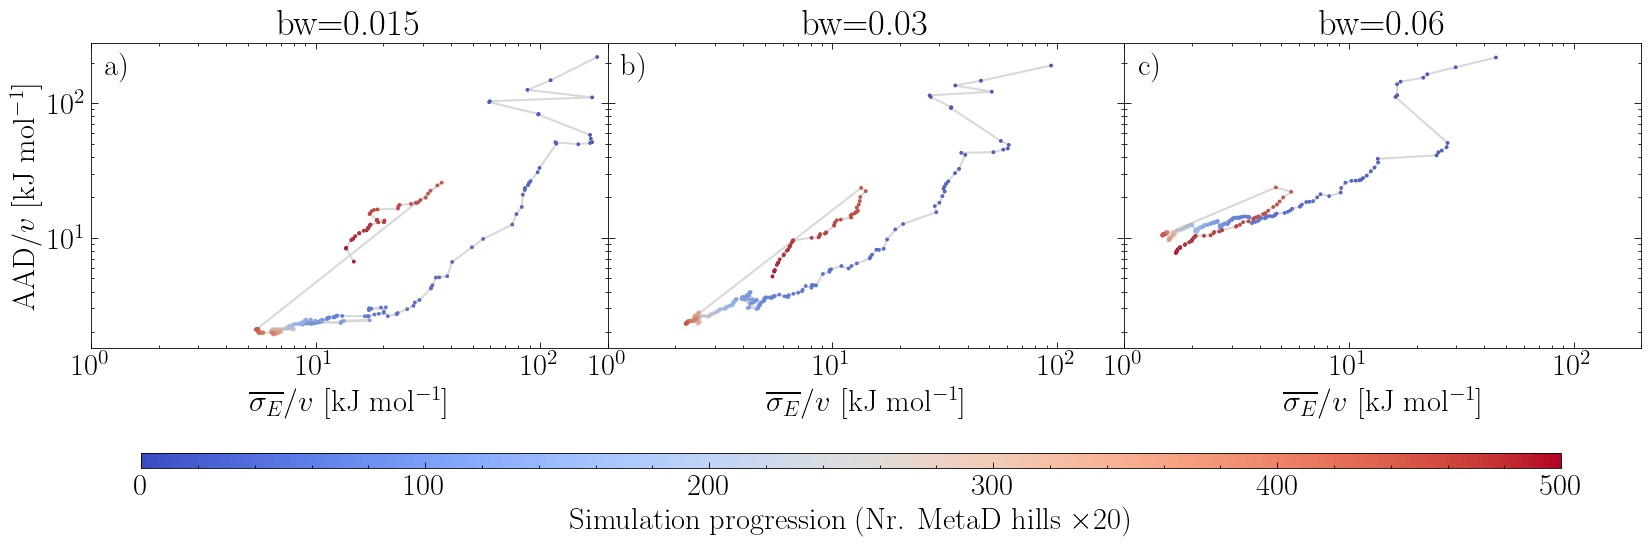

In [22]:
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
fig, axs = plt.subplots(1,3, figsize=(20,5), sharey=True)


####################################################################################################################################
ofe_history_1 = ofe_history_11
volume_history_1 = volume_history_11
aad_history_1 = aad_history_11
cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))

axs[0].scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm, label="error evolution")
axs[0].plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) , c="grey", alpha=0.3); 
axs[0].set_xlabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]"); axs[0].set_ylabel("AAD/$v$ [kJ mol$^{-1}$]"); axs[0].set_xscale("log"); axs[0].set_yscale("log") ;axs[0].set_title("bw=0.015"); 
axs[0].set_xlim(1,200)

####################################################################################################################################
ofe_history_1 = ofe_history_12
volume_history_1 = volume_history_12
aad_history_1 = aad_history_12
cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))

axs[1].scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm, label="error evolution")
axs[1].plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) , c="grey", alpha=0.3); 
axs[1].set_xlabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]"); axs[1].set_xscale("log"); axs[1].set_yscale("log") ;axs[1].set_title("bw=0.03");#; axs[1].set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")
axs[1].set_xlim(1,200)

####################################################################################################################################
ofe_history_1 = ofe_history_13
volume_history_1 = volume_history_13
aad_history_1 = aad_history_13
cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))

scatter = axs[2].scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm, label="error evolution")
axs[2].plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) , c="grey", alpha=0.3); 
axs[2].set_xlabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]"); axs[2].set_xscale("log"); axs[2].set_yscale("log"); axs[2].set_title("bw=0.06");#; axs[2].set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")
axs[2].set_xlim(1,200)

####################################################################################################################################
plt.subplots_adjust(bottom=0.27)
cbar_ax = fig.add_axes([0.15, 0.03, 0.71, 0.03]) 
fig.colorbar(scatter, cax=cbar_ax, label='Simulation progression (Nr. MetaD hills ' + r'$\times$20)', orientation='horizontal')

plt.subplots_adjust(wspace=0)

plt.text(-0.95, 0.92, 'a)', ha='center', va='center', fontsize=22, transform=axs[1].transAxes)
plt.text(0.05, 0.92, 'b)', ha='center', va='center', fontsize=22, transform=axs[1].transAxes)
plt.text(1.05, 0.92, 'c)', ha='center', va='center', fontsize=22, transform=axs[1].transAxes)
# plt.tight_layout()
# plt.savefig(path_Figure_E + 'FigureE_ofe_aad_correlation.png', dpi=600, bbox_inches='tight')
plt.show()

plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False

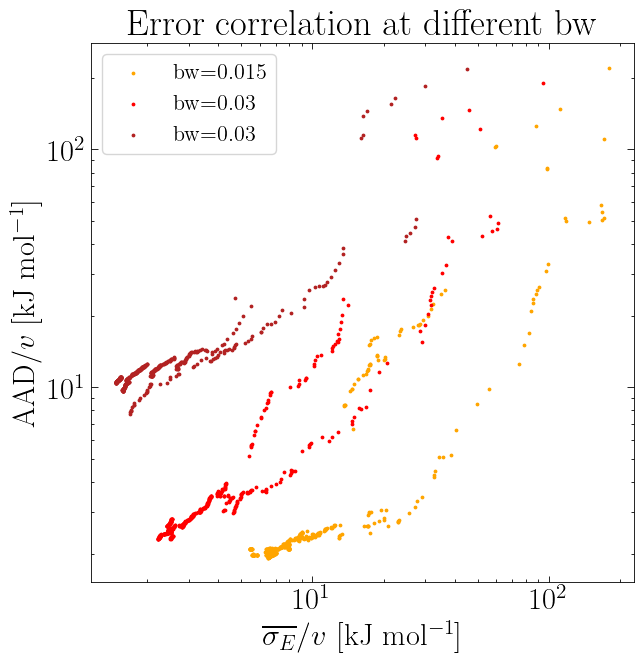

In [23]:
# plt.rcParams['xtick.minor.visible'] = T
plt.figure(figsize=(7,7))

plt.scatter(np.asarray(ofe_history_11) / np.asarray(volume_history_11), np.asarray(aad_history_11) / np.asarray(volume_history_11) ,s=3, c="orange", label="bw=0.015")
plt.scatter(np.asarray(ofe_history_12) / np.asarray(volume_history_12), np.asarray(aad_history_12) / np.asarray(volume_history_12) ,s=3, c="red", label="bw=0.03")
plt.scatter(np.asarray(ofe_history_13) / np.asarray(volume_history_13), np.asarray(aad_history_13) / np.asarray(volume_history_13) ,s=3, c="firebrick", label="bw=0.03")
plt.xlabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]"); plt.ylabel("AAD/$v$ [kJ mol$^{-1}$]"); plt.xscale("log"); plt.yscale("log") #;axs[0].set_title("bw=0.015"); # plt.xlim(1,200)
plt.legend(fontsize=16); plt.title("Error correlation at different bw")
plt.savefig(path_Figure_E + 'FigureE_ofe_aad_correlation_2.png', dpi=600, bbox_inches='tight')
plt.show()

### Multiplot [PD, F + ofe, FES + AD, error_prog v. t, ofe v. aad] x [bw 0.015, 0.03, 0.06]

In [24]:
bw_list = [0.015, 0.03, 0.06]

results = []
    
#Read the HILLS and Colvar data
os.chdir(path_manustript + "Figure1A")
HILLS=MFI1D.load_HILLS(hills_name="HILLS")
position = MFI1D.load_position(position_name="position")
    
for i, bw in enumerate(bw_list):

    #Compute the time-independent mean force and free energy surface
    reselts = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = bw, log_pace = 4000, error_pace = int(len(HILLS)/500), 
                        FES_cutoff=-1, Ftot_den_cutoff=0.1, save_intermediate_fes_error_cutoff = True, use_weighted_st_dev=False)
    X, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_evol, fes_error_cutoff_evol = reselts
    FES_end = FES

    time_evol = []
    aad_evol = []; aad_v_evol = []
    ofe_evol = []; ofe_v_evol = []
    for i in range(len(fes_error_cutoff_evol[0])):
        
        #Find FES and error
        FES = fes_error_cutoff_evol[0,i] 
        AD = abs(FES - y) * fes_error_cutoff_evol[3,i]
        AAD = np.sum(AD) / np.count_nonzero(fes_error_cutoff_evol[3,i])
        volume = np.count_nonzero(fes_error_cutoff_evol[3,i]) / len(fes_error_cutoff_evol[3,i])
        aad_evol.append(AAD)
        aad_v_evol.append(AAD / error_evol[2,i])
        
        ofe_evol.append(error_evol[1,i])
        ofe_v_evol.append(error_evol[1,i] / error_evol[2,i])
        time_evol.append(error_evol[3,i])
        
    results.append([Ftot_den, Ftot, FES, ofe, AD, time_evol, aad_evol, aad_v_evol, ofe_evol, ofe_v_evol])
    
MFI.save_pkl(results, path_manustript + "Figure_E/data_figureE_multiplot[bw_0-015_0-03_0-06].pkl")
    

20.0 %   OFE = 4.7149
40.0 %   OFE = 4.1137
60.0 %   OFE = 3.5652
80.0 %   OFE = 3.457
100.0 %   OFE = 12.3557
20.0 %   OFE = 2.2453
40.0 %   OFE = 1.6781
60.0 %   OFE = 1.4145
80.0 %   OFE = 1.371
100.0 %   OFE = 4.7094
20.0 %   OFE = 1.5551
40.0 %   OFE = 1.1515
60.0 %   OFE = 1.0043
80.0 %   OFE = 0.9387
100.0 %   OFE = 1.5511


In [25]:
# make function to multiplot

# load results
results = MFI.load_pkl(path_manustript + "Figure_E/data_figureE_multiplot[bw_0-015_0-03_0-06].pkl")

[[Ftot_den, Ftot, FES, ofe, AD, time_evol, aad_evol, aad_v_evol, ofe_evol, ofe_v_evol],
 [Ftot_den, Ftot, FES, ofe, AD, time_evol, aad_evol, aad_v_evol, ofe_evol, ofe_v_evol],
 [Ftot_den, Ftot, FES, ofe, AD, time_evol, aad_evol, aad_v_evol, ofe_evol, ofe_v_evol],
 [Ftot_den, Ftot, FES, ofe, AD, time_evol, aad_evol, aad_v_evol, ofe_evol, ofe_v_evol]] = results

# # Prid plot (3x4 with Ftot_den + 1x2 error)
# cutoff_inve19 = np.where(inve_pot < 19, 1, 0)
# plt_list = [np.where(inve_pot < 22, FES_1, np.nan), np.where(np.logical_and(Ftot_den_1>1E-1 , inve_pot < 22 ), Ftot_den_1,np.nan), MFI.zero_to_nan(ofe_1), MFI.zero_to_nan(AD_1), 
#             np.where(np.logical_and(Ftot_den_2>1E-1 , inve_pot < 22 ), FES_2, np.nan), np.where(np.logical_and(Ftot_den_2>1E-1 , inve_pot < 22 ), Ftot_den_2,np.nan), np.where(np.logical_and(inve_pot < 22, ofe_2 > 0), ofe_2, np.nan), MFI.zero_to_nan(AD_2), 
#             np.where(inve_pot < 22, FES_3, np.nan), np.where(np.logical_and(Ftot_den_3>1E-1 , inve_pot < 22 ), Ftot_den_3,np.nan), MFI.zero_to_nan(ofe_3), MFI.zero_to_nan(AD_3)]
# levels_list = [np.arange(0, 20, 1), [0.01, 0.1, 1, 2.5, 5, 10, 25, 50, 100, 225, 500, 1000], np.arange(0, 39, 1), np.arange(0, 7, 1)]
# # levels_list = [np.arange(0, 20, 1), [0.01, 0.1, 1, 2.5, 5, 10, 25, 50, 100, 225, 500, 1000], [20,21,22,23,24,25,26,27,28,29,30,40,50], np.arange(0, 7, 1)]
# levels_list = levels_list + levels_list + levels_list
               
# PD_tick_loc = [0.01, 0.055, 0.1, 0.55, 1, 1.75, 2.5, 3.75, 5, 7.5, 10, 17.5, 25, 37.5, 50, 75, 100, 162.5, 225, 362.5, 500, 750, 1000]
# cbar_loc = [0,0,0,0,0,0,0,0,  -3, -2, -1, 0]
# cbar_label = ["","","","","","","","",  "FES [kJ mol$^{-1}$]", "PD [-]", "$\sigma_E$ [kJ mol$^{-1}$]", "AD [kJ mol$^{-1}$]"]
# title_list = ["Free Energy Surface", "Biased Probability Density", "Mean Force Error",  "Absolute Deviation"]

# d=0.2
# hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+1.5*d,-0.35-1.5*d],[-0.1+2*d,-0.1-2*d],[0.15+2.5*d,0.15-2.5*d], [0.4+2.5*d, 0.4-2.5*d], [-0.3-2.5*d,-0.3+2.5*d],[-0-2.5*d,-0+2.5*d],[0.3-2.5*d,0.3+2.5*d],[0.6-2.5*d,0.6+2.5*d]]  #AAD 1.19 k=35 d=0.2

# fig = plt.figure(figsize=(20,20))

# # Define the GridSpec with a spacer
# gs = gridspec.GridSpec(5, 4, height_ratios=[1, 1, 1, 0.5, 1])

# ax = []

# # Create subplots for the first 3 rows with shared axes
# for i in range(3):
#     for j in range(4):
#         if i == 0 and j == 0:
#             ax.append(fig.add_subplot(gs[i, j]))
#         else:
#             ax.append(fig.add_subplot(gs[i, j], sharex=ax[0], sharey=ax[0]))

# # Create the subplot for the fifth row (after the spacer)
# # ax.append(fig.add_subplot(gs[4, :]))

# # Plot the sample data on each of the subplots
# for axis in range(len(ax[:-4])):
#     if axis == 1 or axis == 5 : ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8, norm=colors.LogNorm(vmin=0.1, vmax=1000))
#     else: ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)
#     if axis < 4: ax[axis].set_title(title_list[axis])
    
# for axis in range(len(ax))[-4:]:
#     if axis == 9: 
#         contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8, norm=colors.LogNorm(vmin=0.1, vmax=1000))    
#         axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], -1/5, 1, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
#         cbar = fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])
#         cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(PD_tick_loc))
#     else: 
#         contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)    
#         axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], -1/5, 1, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
#         fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])

# for j in [9]: 
#     for i in range(len(hp_centre)): ax[j].scatter(hp_centre[i][0], hp_centre[i][1], c="r", alpha=0.3, s=200)

# # ax = ax[:-1]
# gs = gridspec.GridSpec(5, 100, height_ratios=[1, 1, 1, 0.4, 1])
# ax.append(fig.add_subplot(gs[4, 1:47]))
# ax.append(fig.add_subplot(gs[4, 53:]))

# # ax[-2].plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1),color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
# # ax[-2].plot( time_history_2, np.asarray(ofe_history_2) / np.asarray(volume_history_2) ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
# # ax[-2].plot( time_history_3, np.asarray(ofe_history_3) / np.asarray(volume_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")

# ax[-2].plot( time_history_1, np.asarray(ofe_history_1),color='black',alpha=0.5,linewidth=3,label="1 MetaD")
# ax[-2].plot( time_history_2, np.asarray(ofe_history_2) ,color='red',alpha=0.5,linewidth=3, label="20 MetaD")
# ax[-2].plot( time_history_3, np.asarray(ofe_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP")

# ax[-2].set_xlabel("Simulation steps"); ax[-2].set_ylabel("$\overline{\sigma_E}/ v$  [kJ mol$^{-1}$]")
# ax[-2].set_ylim(0,25); 
# ax[-2].legend(fontsize=14);

# # ax[-1].plot( time_history_1, np.asarray(aad_history_1) / np.asarray(volume_history_1) ,color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
# # ax[-1].plot( time_history_2, np.asarray(aad_history_2) / np.asarray(volume_history_2) ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
# # ax[-1].plot( time_history_3, np.asarray(aad_history_3) / np.asarray(volume_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")

# ax[-1].plot( time_history_1, np.asarray(aad_history_1)[:,1],color='black',alpha=0.5,linewidth=3,label="1 MetaD")
# ax[-1].plot( time_history_2, np.asarray(aad_history_2)[:,1],color='red',alpha=0.5,linewidth=3,  label="20 MetaD")
# ax[-1].plot( time_history_3, np.asarray(aad_history_3)[:,1],color='blue',alpha=0.5,linewidth=3, label="10 MetaD and 10 MetaD+HP")
# ax[-1].set_xlabel("Simulation steps"); 
# ax[-1].set_ylabel("AAD$/v$ [kJ mol$^{-1}$]")
# ax[-1].set_ylim(0,7); 
# ax[-1].legend(fontsize=14);


# for i in range(9):
#     if i % 4 != 0: plt.setp(ax[i].get_yticklabels(), visible=False)
#     if i < 8: plt.setp(ax[i].get_xticklabels(), visible=False)
#     # ax[i].tick_params(left=False, right=False, bottom=False, top=False)
    
# # h_text = [0.862, 0.691, 0.52, 0.27]
# # w_text = [0.133, 0.325, 0.52, 0.715]
# # fig.text(w_text[0], h_text[0], "a)"); fig.text(w_text[1], h_text[0], "b)"); fig.text(w_text[2], h_text[0], "c)"); fig.text(w_text[3], h_text[0], "d)")
# # fig.text(w_text[0], h_text[1], "e)"); fig.text(w_text[1], h_text[1], "f)"); fig.text(w_text[2], h_text[1], "g)"); fig.text(w_text[3], h_text[1], "h)")
# # fig.text(w_text[0], h_text[2], "i)"); fig.text(w_text[1], h_text[2], "j)"); fig.text(w_text[2], h_text[2], "k)"); fig.text(w_text[3], h_text[2], "l)")
# # fig.text(w_text[0]+0.005, h_text[3], "m)")
# # fig.text(w_text[2]+0.022, h_text[3], "n)")

# plt.subplots_adjust(wspace=0, hspace=0)
# # plt.savefig(path_manustript + 'Figure3/Figure3.png', dpi=600, bbox_inches='tight')

# plt.show()

ValueError: not enough values to unpack (expected 4, got 3)

### Multiplot [PD, F + ofe, FES + AD, error_prog v. t, ofe v. aad] x [nh 1_000, 10_000, 100_000]

### Error plots for initial draft

#### Subplot 1

In [ ]:
[time_history_1, ofe_history_1, aad_history_1 ,volume_history_1] = MFI.load_pkl(path_Figure_E + "data_figure_E_1A.pkl")

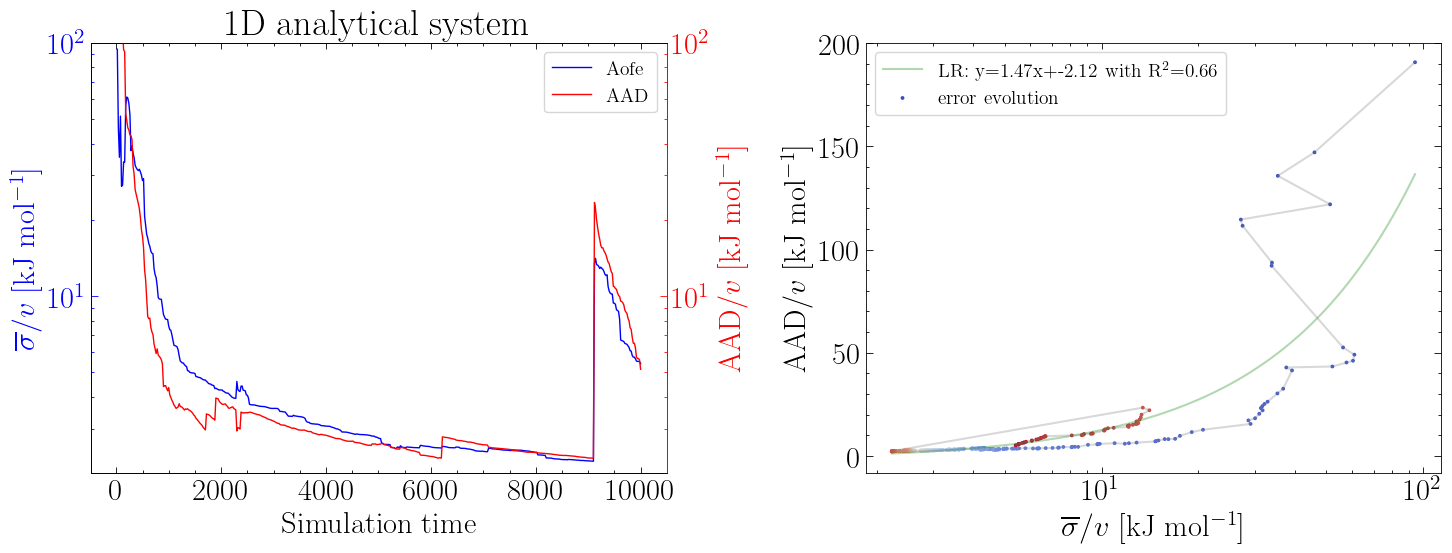

In [ ]:
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

fig, (ax1, ax3) = plt.subplots(1,2,figsize=(15,6))
ax2 = ax1.twinx()

ax1.plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1) ,color='blue',linewidth=1,label="Aofe")
ax2.plot( time_history_1, np.asarray(aad_history_1) / np.asarray(volume_history_1) ,color='red',linewidth=1,label="AAD")
ax1.set_xlabel("Simulation time"); ax1.set_ylabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]", c="blue"); ax2.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 
ax1.set_ylim(0,30)
ax2.set_ylim(0,30)
handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)
# plt.show()
ax1.tick_params(axis='y', which='both', colors='blue')
ax1.spines['right'].set_color('blue')        # setting up Y-axis tick color to red
ax2.tick_params(axis='y', which='both', colors='red')
ax2.spines['right'].set_color('red')        # setting up Y-axis tick color to red

##############################################################################################################
from scipy import stats
slope, intercept, r, p, se = stats.linregress(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1))
x_line = np.linspace(min(np.asarray(ofe_history_1) / np.asarray(volume_history_1)), max(np.asarray(ofe_history_1) / np.asarray(volume_history_1)), 200)

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))
# plt.figure(figsize=(15,5))

# plt.subplot(1,3,3)
ax3.plot(x_line, x_line*slope + intercept, c="green", alpha=0.3, label="LR: y=" + str(round(slope,2)) + "x+" + str(round(intercept,2)) + " with R$^2$=" + str(round(r**2,2)))

ax3.scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm, label="error evolution")
ax3.plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) , c="grey", alpha=0.3); 
ax3.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); ax3.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]"); ax3.set_xscale("log")#; plt.yscale("log");ax3.set_title("aad/v vs. ofe/v"); 
ax3.legend(fontsize=14)
# handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)

plt.tight_layout()
plt.show()

plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False

#### Subplot 2

In [ ]:
[time_history_2, ofe_history_2, aad_history_2 ,volume_history_2] = MFI.load_pkl(path_Figure_E + "data_figure_E_1B.pkl")

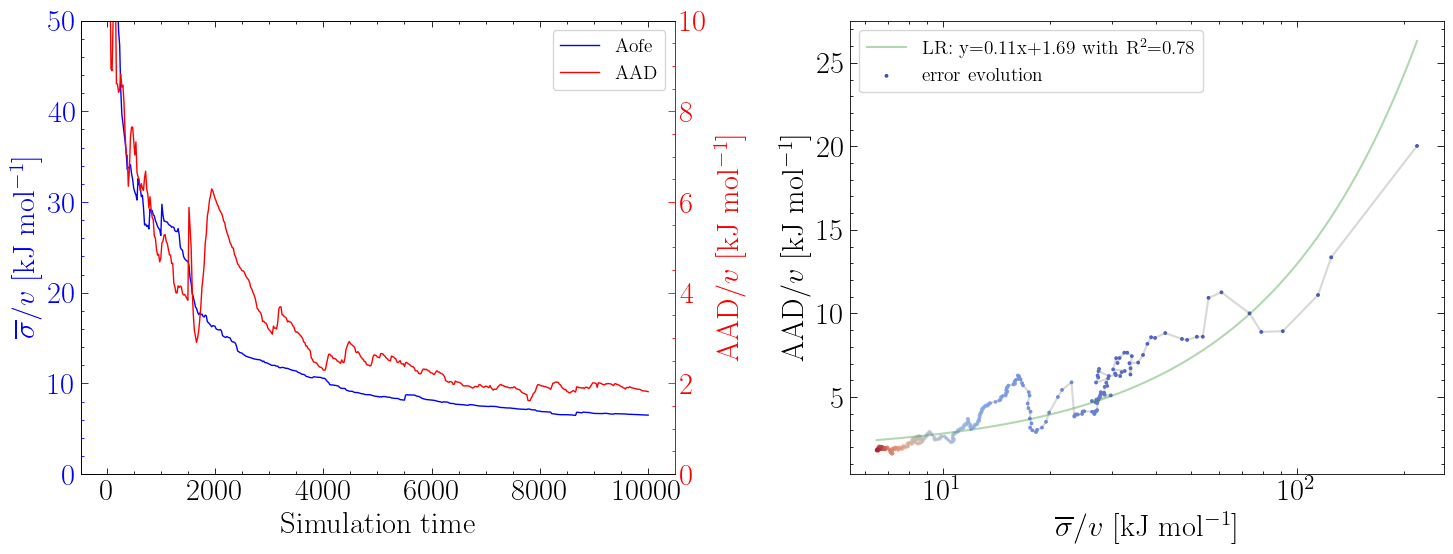

In [ ]:
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

fig, (ax1, ax3) = plt.subplots(1,2,figsize=(15,6))
ax2 = ax1.twinx()

ax1.plot( time_history_2, np.asarray(ofe_history_2) / np.asarray(volume_history_2) ,color='blue',linewidth=1,label="Aofe")
ax2.plot( time_history_2, np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,color='red',linewidth=1,label="AAD")
ax1.set_xlabel("Simulation time"); ax1.set_ylabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]", c="blue"); ax2.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 
ax1.set_ylim(0,50)
ax2.set_ylim(0,10)
handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)
# plt.show()
ax1.tick_params(axis='y', which='both', colors='blue')
ax1.spines['right'].set_color('blue')        # setting up Y-axis tick color to red
ax2.tick_params(axis='y', which='both', colors='red')
ax2.spines['right'].set_color('red')        # setting up Y-axis tick color to red

##############################################################################################################
slope, intercept, r, p, se = stats.linregress(np.asarray(ofe_history_2) / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2))
x_line = np.linspace(min(np.asarray(ofe_history_2) / np.asarray(volume_history_2)), max(np.asarray(ofe_history_2) / np.asarray(volume_history_2)), 200)

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_2))
# plt.figure(figsize=(15,5))

# plt.subplot(1,3,3)
ax3.plot(x_line, x_line*slope + intercept, c="green", alpha=0.3, label="LR: y=" + str(round(slope,2)) + "x+" + str(round(intercept,2)) + " with R$^2$=" + str(round(r**2,2)))

ax3.scatter(np.asarray(ofe_history_2) / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,s=3, c=range(len(ofe_history_2)), cmap=cmap, norm=norm, label="error evolution")
ax3.plot(np.asarray(ofe_history_2) / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) , c="grey", alpha=0.3); 
ax3.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); ax3.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]"); ax3.set_xscale("log")#; plt.yscale("log");ax3.set_title("aad/v vs. ofe/v"); 
ax3.legend(fontsize=14)
# handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)

plt.tight_layout()
plt.show()

plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False

#### Subplot 3

In [ ]:
[time_history_31, ofe_history_31, aad_history_31 ,volume_history_31] = MFI.load_pkl(path_manustript +"Figure_E/" + "data_figure_E_2_1.pkl")
[time_history_32, ofe_history_32, aad_history_32 ,volume_history_32] = MFI.load_pkl(path_manustript +"Figure_E/" + "data_figure_E_2_2.pkl")
[time_history_33, ofe_history_33, aad_history_33 ,volume_history_33] = MFI.load_pkl(path_manustript +"Figure_E/" + "data_figure_E_2_3.pkl")


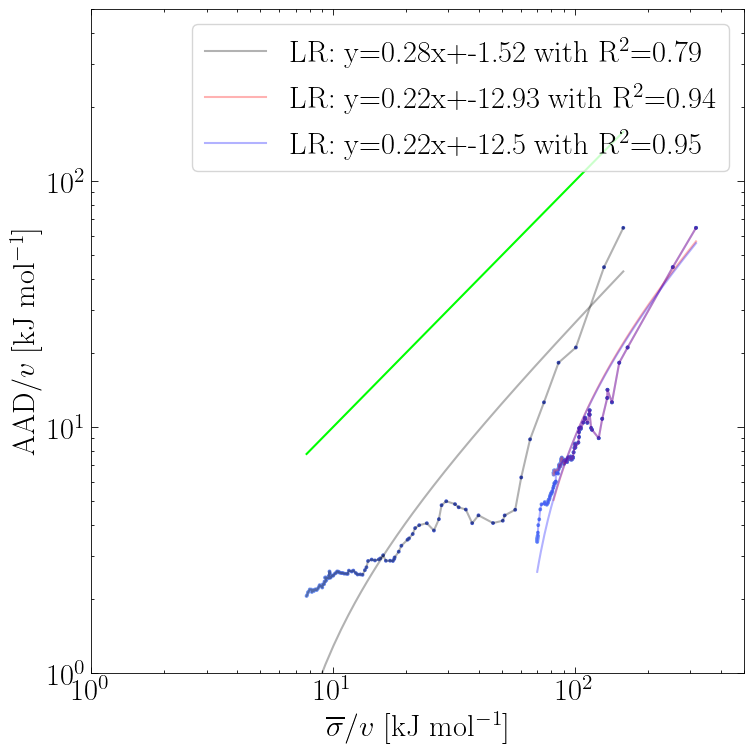

In [ ]:
cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))

slope_31, intercept_31, r_31, p_31, se_31 = stats.linregress(np.asarray(ofe_history_31) / np.asarray(volume_history_31), np.asarray(aad_history_31)[:,1] / np.asarray(volume_history_31))
slope_32, intercept_32, r_32, p_32, se_32 = stats.linregress(np.asarray(ofe_history_32) / np.asarray(volume_history_32), np.asarray(aad_history_32)[:,1] / np.asarray(volume_history_32))
slope_33, intercept_33, r_33, p_33, se_33 = stats.linregress(np.asarray(ofe_history_33) / np.asarray(volume_history_33), np.asarray(aad_history_33)[:,1] / np.asarray(volume_history_33))
x_line_31 = np.linspace(min(np.asarray(ofe_history_31) / np.asarray(volume_history_31)), max(np.asarray(ofe_history_31) / np.asarray(volume_history_31)), 200)
x_line_32 = np.linspace(min(np.asarray(ofe_history_32) / np.asarray(volume_history_32)), max(np.asarray(ofe_history_32) / np.asarray(volume_history_32)), 200)
x_line_33 = np.linspace(min(np.asarray(ofe_history_33) / np.asarray(volume_history_33)), max(np.asarray(ofe_history_33) / np.asarray(volume_history_33)), 200)


plt.figure(figsize=(8,8))
plt.scatter(np.asarray(ofe_history_31) / np.asarray(volume_history_31), np.asarray(aad_history_31)[:,1] / np.asarray(volume_history_31) ,s=3, c=range(len(ofe_history_31)), cmap=cmap, norm=norm)
plt.plot(np.asarray(ofe_history_31) / np.asarray(volume_history_31), np.asarray(aad_history_31)[:,1] / np.asarray(volume_history_31) , c="black", alpha=0.3); 
plt.plot(x_line_31, x_line_31*slope_31 + intercept_31, c="black", alpha=0.3, label="LR: y=" + str(round(slope_31,2)) + "x+" + str(round(intercept_31,2)) + " with R$^2$=" + str(round(r_31**2,2)))

plt.scatter(np.asarray(ofe_history_32)  / np.asarray(volume_history_32), np.asarray(aad_history_32)[:,1]  / np.asarray(volume_history_32) ,s=3, c=range(len(ofe_history_32)), cmap=cmap, norm=norm)
plt.plot(np.asarray(ofe_history_32)  / np.asarray(volume_history_32), np.asarray(aad_history_32)[:,1]  / np.asarray(volume_history_32), c="red", alpha=0.3);
plt.plot(x_line_32, x_line_32*slope_32 + intercept_32, c="red", alpha=0.3, label="LR: y=" + str(round(slope_32,2)) + "x+" + str(round(intercept_32,2)) + " with R$^2$=" + str(round(r_32**2,2)))

plt.scatter(np.asarray(ofe_history_33) / np.asarray(volume_history_33), np.asarray(aad_history_33)[:,1] / np.asarray(volume_history_33) ,s=3, c=range(len(ofe_history_33)), cmap=cmap, norm=norm)
plt.plot(np.asarray(ofe_history_33) / np.asarray(volume_history_33), np.asarray(aad_history_33)[:,1] / np.asarray(volume_history_33), c="blue", alpha=0.3); 
plt.plot(x_line_33, x_line_33*slope_33 + intercept_33, c="blue", alpha=0.3, label="LR: y=" + str(round(slope_33,2)) + "x+" + str(round(intercept_33,2)) + " with R$^2$=" + str(round(r_33**2,2)))

plt.plot(x_line_31, x_line_31, c="lime")

plt.xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); plt.ylabel("AAD/$v$ [kJ mol$^{-1}$]")#; plt.title("10 MetaD + 10 MetaD+US")
plt.ylim(1,500); plt.xlim(1,500)
plt.xscale("log"); plt.yscale("log")
plt.legend(); plt.tight_layout(); plt.show()

### Combine all together

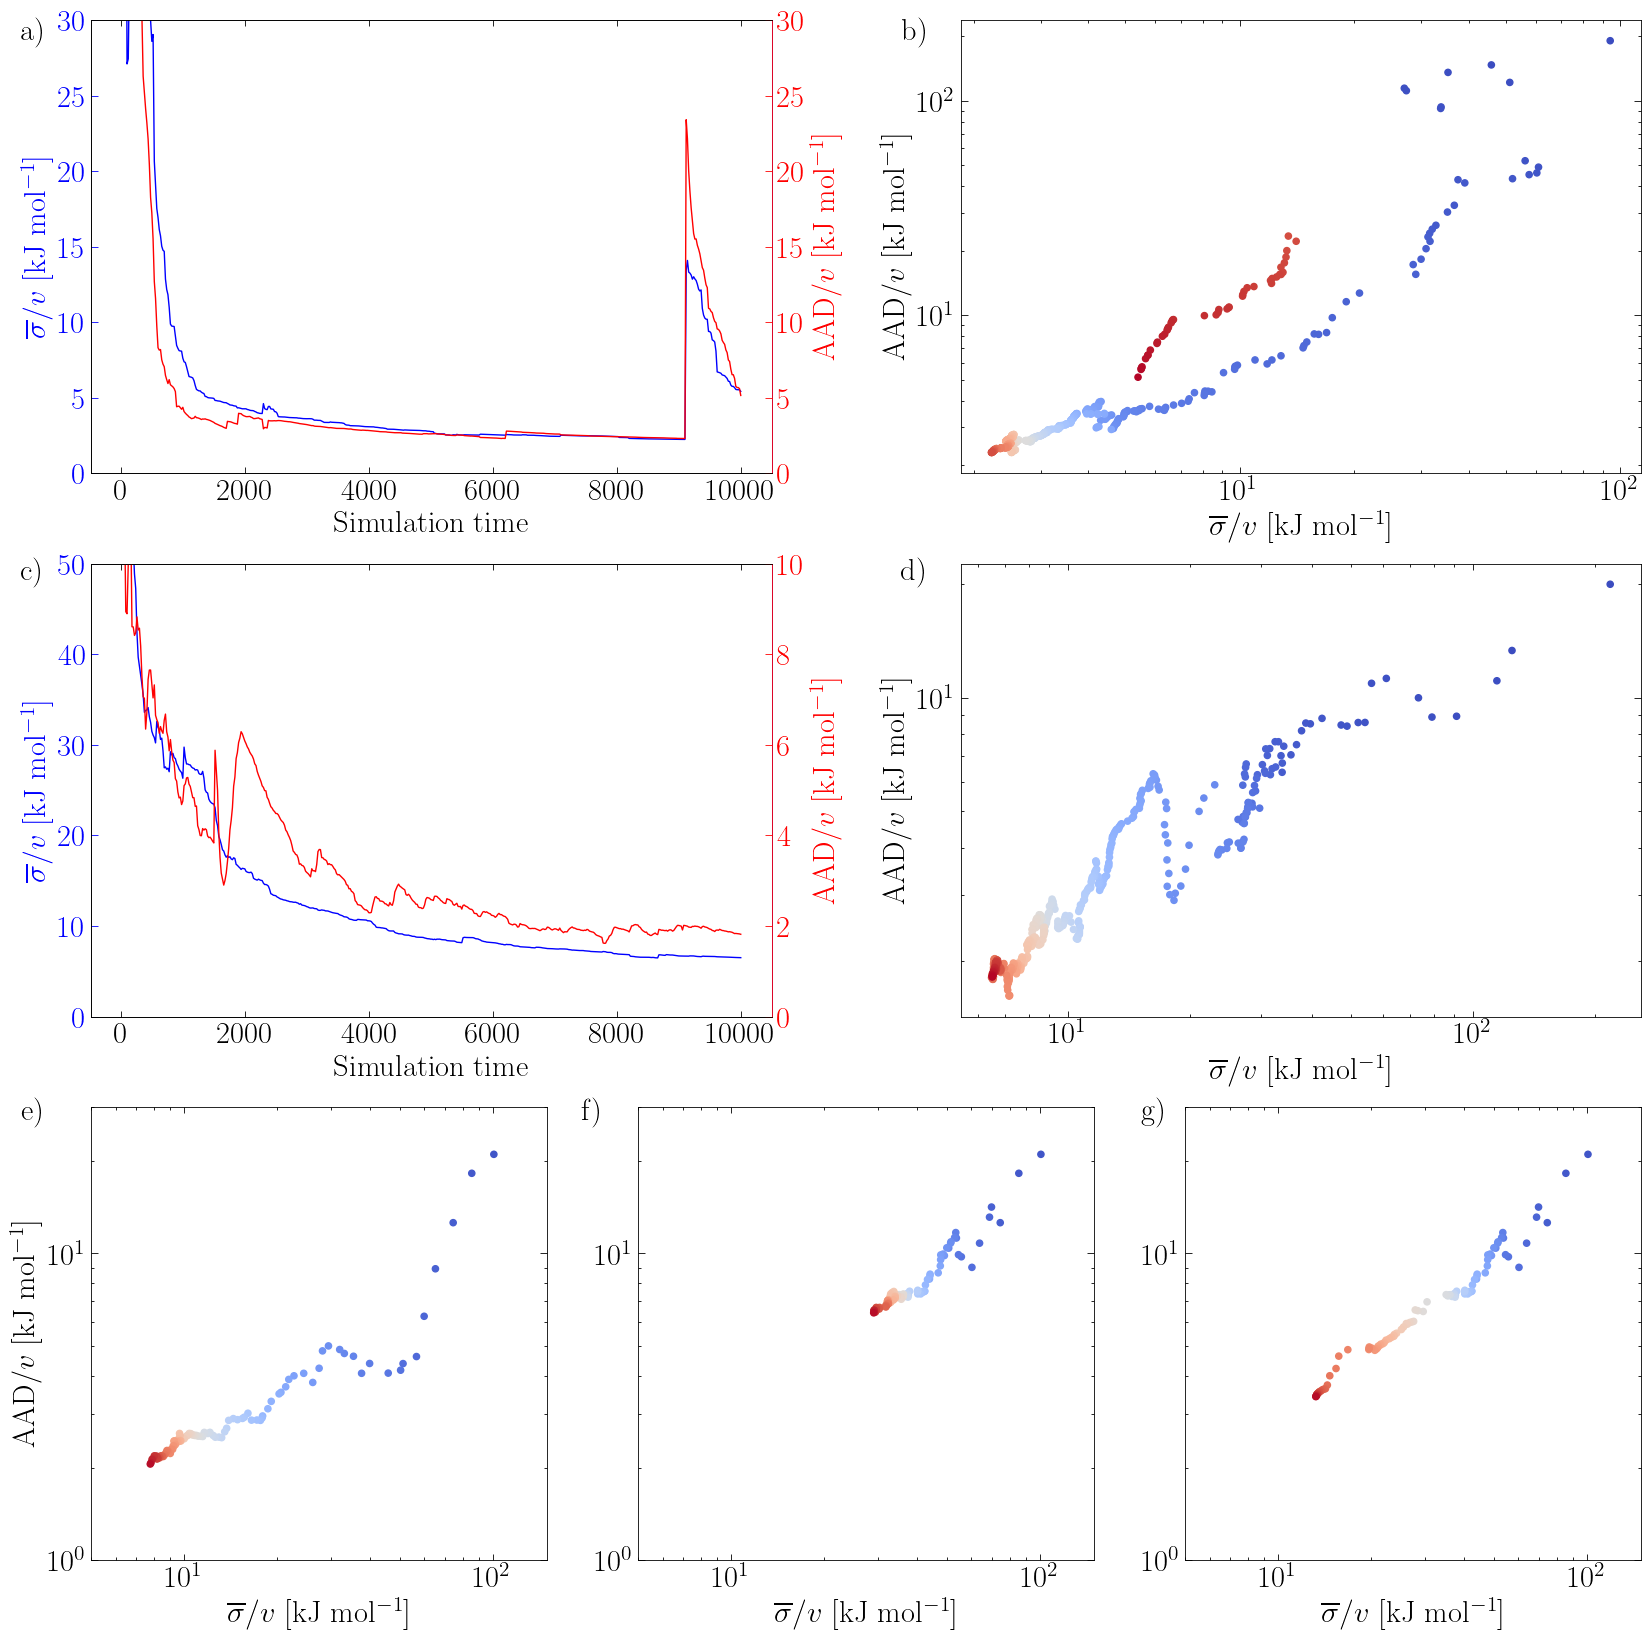

In [ ]:
# plt.rcParams['xtick.minor.visible'] = True
# plt.rcParams['ytick.minor.visible'] = True

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(3, 100, height_ratios=[1, 1, 1])


ax1 = fig.add_subplot(gs[0, :44])
ax2 = ax1.twinx()
ax3 = fig.add_subplot(gs[0, 56:])  
ax4 = fig.add_subplot(gs[1, :44]) 
ax5 = ax4.twinx() 
ax6 = fig.add_subplot(gs[1, 56:])  

gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1])

ax7 = fig.add_subplot(gs[2, 0]) 
ax8 = fig.add_subplot(gs[2, 1], sharex=ax7, sharey=ax7)  
ax9 = fig.add_subplot(gs[2, 2], sharex=ax7, sharey=ax7) 
##############################################################################################################
##############################################################################################################


ax1.plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1) ,color='blue',linewidth=1)
ax2.plot( time_history_1, np.asarray(aad_history_1) / np.asarray(volume_history_1) ,color='red',linewidth=1)
ax1.set_xlabel("Simulation time"); ax1.set_ylabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]", c="blue"); ax2.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 
ax1.set_ylim(0,30)
ax2.set_ylim(0,30)
# handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)
# plt.show()
ax1.tick_params(axis='y', which='both', colors='blue')
ax1.spines['right'].set_color('blue')        # setting up Y-axis tick color to red
ax2.tick_params(axis='y', which='both', colors='red')
ax2.spines['right'].set_color('red')        # setting up Y-axis tick color to red

##############################################################################################################
from scipy import stats
slope, intercept, r, p, se = stats.linregress(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1))
x_line = np.linspace(min(np.asarray(ofe_history_1) / np.asarray(volume_history_1)), max(np.asarray(ofe_history_1) / np.asarray(volume_history_1)), 200)

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))
# plt.figure(figsize=(15,5))

# plt.subplot(1,3,3)
# ax3.plot(x_line, x_line*slope + intercept, c="grey", alpha=0.3, label="LR: y=" + str(round(slope,2)) + "x+" + str(round(intercept,2)) + " with R$^2$=" + str(round(r**2,2)), linestyle='dashed')

ax3.scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) ,s=20, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
# ax3.plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) , c="grey", alpha=0.3, label="error evolution"); 
ax3.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); ax3.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]"); ax3.set_xscale("log"); ax3.set_yscale("log")#;ax3.set_title("aad/v vs. ofe/v"); 
# ax3.legend(fontsize=14)
# handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)


##############################################################################################################
##############################################################################################################


ax4.plot( time_history_2, np.asarray(ofe_history_2) / np.asarray(volume_history_2) ,color='blue',linewidth=1,label="Aofe")
ax5.plot( time_history_2, np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,color='red',linewidth=1,label="AAD")
ax4.set_xlabel("Simulation time"); ax4.set_ylabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]", c="blue"); ax5.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 
ax4.set_ylim(0,50)
ax5.set_ylim(0,10)
# handles1, labels1 = ax4.get_legend_handles_labels() ; handles2, labels2 = ax5.get_legend_handles_labels(); ax4.legend(handles1 + handles2, labels1 + labels2, fontsize=14)
# plt.show()
ax4.tick_params(axis='y', which='both', colors='blue')
ax4.spines['right'].set_color('blue')        # setting up Y-axis tick color to red
ax5.tick_params(axis='y', which='both', colors='red')
ax5.spines['right'].set_color('red')        # setting up Y-axis tick color to red

##############################################################################################################
slope, intercept, r, p, se = stats.linregress(np.asarray(ofe_history_2) / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2))
x_line = np.linspace(min(np.asarray(ofe_history_2) / np.asarray(volume_history_2)), max(np.asarray(ofe_history_2) / np.asarray(volume_history_2)), 200)

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_2))
# plt.figure(figsize=(15,5))

# plt.subplot(1,3,3)
# ax6.plot(x_line, x_line*slope + intercept, c="grey", alpha=0.3, label="LR: y=" + str(round(slope,2)) + "x+" + str(round(intercept,2)) + " with R$^2$=" + str(round(r**2,2)), linestyle='dashed')

ax6.scatter(np.asarray(ofe_history_2) / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,s=20, c=range(len(ofe_history_2)), cmap=cmap, norm=norm)
# ax6.plot(np.asarray(ofe_history_2) / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) , c="grey", alpha=0.3, label="error evolution"); 
ax6.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); ax6.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]"); ax6.set_xscale("log"); ax6.set_yscale("log")#;ax6.set_title("aad/v vs. ofe/v"); 
# ax6.legend(fontsize=14)
# handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)


##############################################################################################################
##############################################################################################################
norm = plt.Normalize(0, len(ofe_history_31))

ax7.scatter(np.asarray(ofe_history_31) / np.asarray(volume_history_31), np.asarray(aad_history_31)[:,1] / np.asarray(volume_history_31) ,s=20, c=range(len(ofe_history_31)), cmap=cmap, norm=norm)
# ax7.plot(np.asarray(ofe_history_31) / np.asarray(volume_history_31), np.asarray(aad_history_31)[:,1] / np.asarray(volume_history_31) , c="black", alpha=0.3, label="error evolution"); 
# ax7.plot(x_line_31, x_line_31*slope_31 + intercept_31, c="black", alpha=0.3, label="LR: y=" + str(round(slope_31,2)) + "x+" + str(round(intercept_31,2)) + " with R$^2$=" + str(round(r_31**2,2)), linestyle='dashed')
ax7.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); 
ax7.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")#; plt.title("10 MetaD + 10 MetaD+US")
ax7.set_xscale("log"); ax7.set_yscale("log")
ax7.set_ylim(1, 30); ax7.set_xlim(5, 150)
# ax7.legend(fontsize=14); 

##############################################################################################################


ax8.scatter(np.asarray(ofe_history_32)  / np.asarray(volume_history_32), np.asarray(aad_history_32)[:,1]  / np.asarray(volume_history_32) ,s=20, c=range(len(ofe_history_32)), cmap=cmap, norm=norm)
# ax8.plot(np.asarray(ofe_history_32)  / np.asarray(volume_history_32), np.asarray(aad_history_32)[:,1]  / np.asarray(volume_history_32), c="red", alpha=0.3, label="error evolution");
# ax8.plot(x_line_32, x_line_32*slope_32 + intercept_32, c="red", alpha=0.3, label="LR: y=" + str(round(slope_32,2)) + "x+" + str(round(intercept_32,2)) + " with R$^2$=" + str(round(r_32**2,2)), linestyle='dashed')
ax8.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); 
# ax8.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")#; plt.title("10 MetaD + 10 MetaD+US")
ax8.set_xscale("log"); ax8.set_yscale("log")
ax8.set_ylim(1, 30); ax8.set_xlim(5, 150)
# ax8.legend(fontsize=14); 

##############################################################################################################


ax9.scatter(np.asarray(ofe_history_33) / np.asarray(volume_history_33), np.asarray(aad_history_33)[:,1] / np.asarray(volume_history_33) ,s=20, c=range(len(ofe_history_33)), cmap=cmap, norm=norm)
# ax9.plot(np.asarray(ofe_history_33) / np.asarray(volume_history_33), np.asarray(aad_history_33)[:,1] / np.asarray(volume_history_33), c="blue", alpha=0.3, label="error evolution"); 
# ax9.plot(x_line_33, x_line_33*slope_33 + intercept_33, c="blue", alpha=0.3, label="LR: y=" + str(round(slope_33,2)) + "x+" + str(round(intercept_33,2)) + " with R$^2$=" + str(round(r_33**2,2)), linestyle='dashed')
ax9.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); 
# ax9.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")#; plt.title("10 MetaD + 10 MetaD+US")
ax9.set_xscale("log"); ax9.set_yscale("log")
ax9.set_ylim(1, 30); ax9.set_xlim(5, 150)
# ax9.legend(fontsize=14); 
# plt.plot(x_line_31, x_line_31, c="lime")

# plt.xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); plt.ylabel("AAD/$v$ [kJ mol$^{-1}$]")#; plt.title("10 MetaD + 10 MetaD+US")
# plt.ylim(1,500); plt.xlim(1,500)
# plt.xscale("log"); plt.yscale("log")

h = [0.87, 0.6, 0.33]
w = [0.09, 0.53]
w2 = [w[0], 0.37, 0.65]

fig.text(x=w[0], y=h[0], s="a)"); fig.text(x=w[1], y=h[0], s="b)")
fig.text(x=w[0], y=h[1], s="c)"); fig.text(x=w[1], y=h[1], s="d)")
fig.text(x=w2[0], y=h[2], s="e)"); fig.text(x=w2[1], y=h[2], s="f)"); fig.text(x=w2[2], y=h[2], s="g)")


# fig.text(x=0.445, y=1, s="1D Analytical Potential")
# fig.text(x=0.46, y=0.67, s="Alanine Dipeptide")
# fig.text(x=0.46, y=0.32, s="Invernizzi Potential")

# plt.tight_layout(); 

plt.savefig(path_Figure_E + 'FigureE_1.png', dpi=600, bbox_inches='tight')

plt.show()
# plt.rcParams['xtick.minor.visible'] = False
# plt.rcParams['ytick.minor.visible'] = False

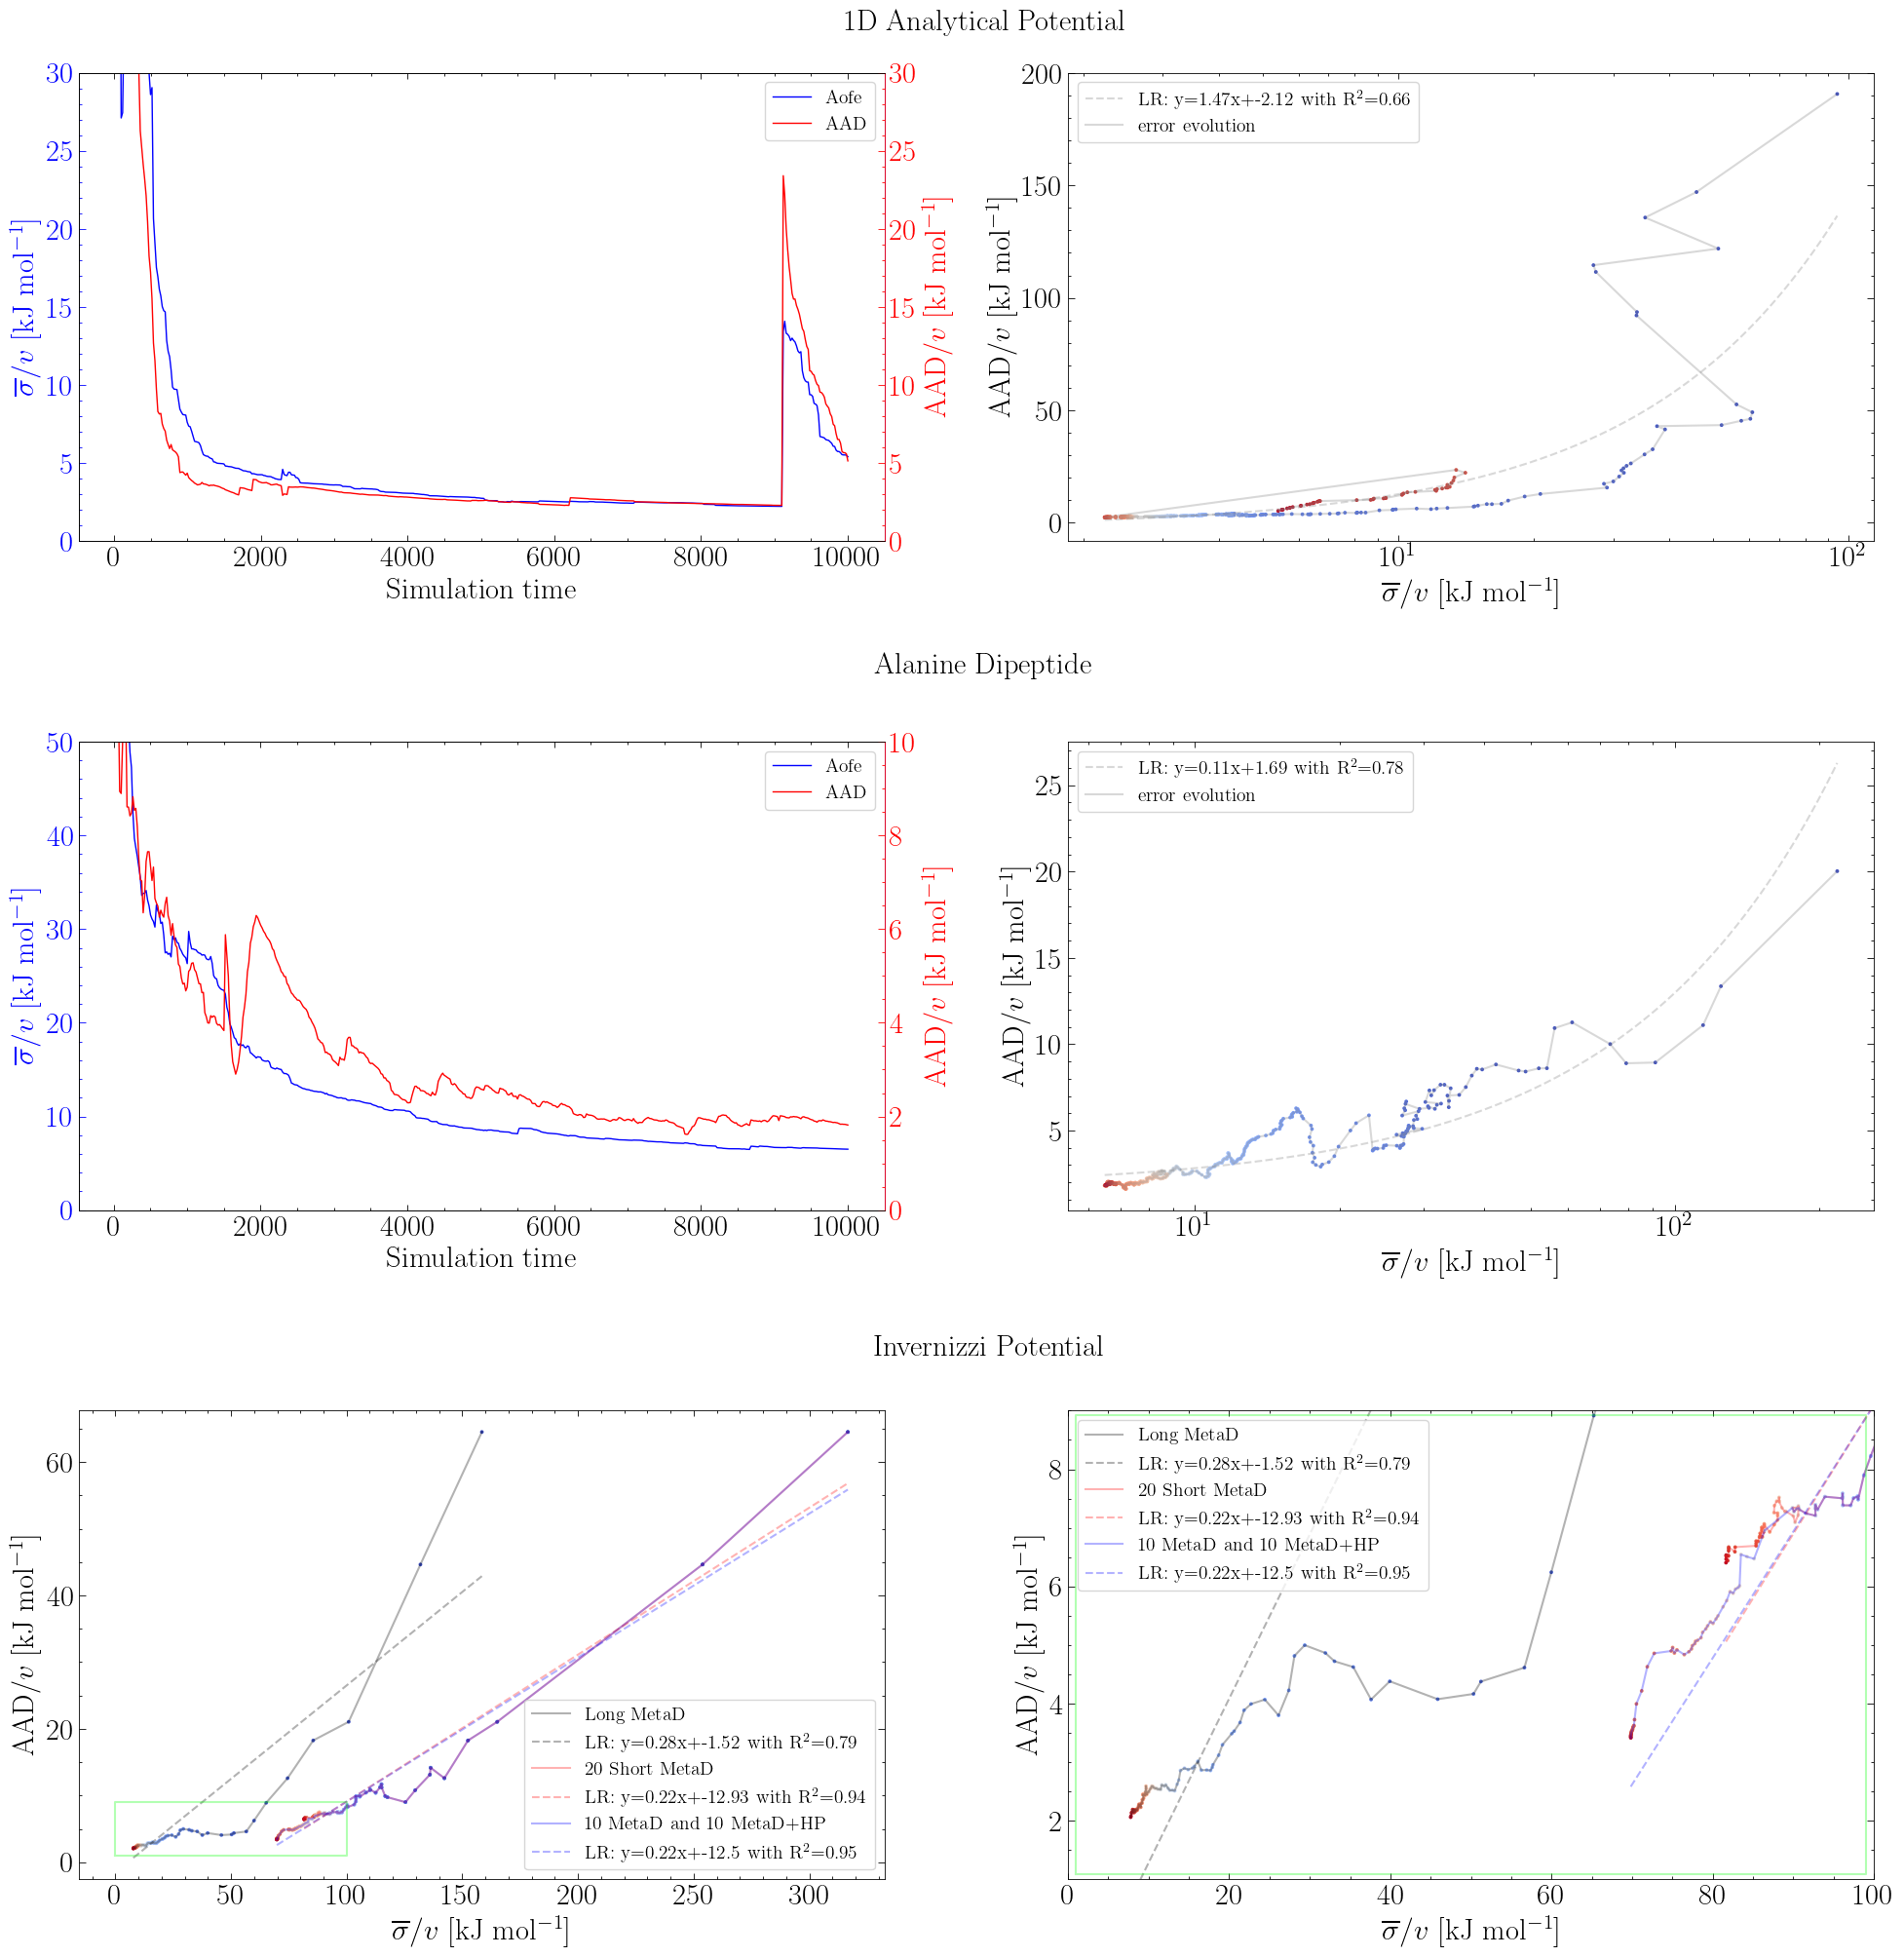

In [ ]:
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(5, 6, height_ratios=[1, 0.0, 1, 0.0, 1])


ax1 = fig.add_subplot(gs[0, :3])
ax2 = ax1.twinx()
ax3 = fig.add_subplot(gs[0, 3:])  # First row, second and third column combined
ax4 = fig.add_subplot(gs[2, :3])  # Second row, first column
ax5 = ax4.twinx()  # Second y-axis for the fourth plot
ax6 = fig.add_subplot(gs[2, 3:])  # Second row, second and third column combined
ax7 = fig.add_subplot(gs[4, :3])  # Third row, first column
ax8 = fig.add_subplot(gs[4, 3:])  # Third row, second column
##############################################################################################################
##############################################################################################################


ax1.plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1) ,color='blue',linewidth=1,label="Aofe")
ax2.plot( time_history_1, np.asarray(aad_history_1) / np.asarray(volume_history_1) ,color='red',linewidth=1,label="AAD")
ax1.set_xlabel("Simulation time"); ax1.set_ylabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]", c="blue"); ax2.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 
ax1.set_ylim(0,30)
ax2.set_ylim(0,30)
handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)
# plt.show()
ax1.tick_params(axis='y', which='both', colors='blue')
ax1.spines['right'].set_color('blue')        # setting up Y-axis tick color to red
ax2.tick_params(axis='y', which='both', colors='red')
ax2.spines['right'].set_color('red')        # setting up Y-axis tick color to red

##############################################################################################################
from scipy import stats
slope, intercept, r, p, se = stats.linregress(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1))
x_line = np.linspace(min(np.asarray(ofe_history_1) / np.asarray(volume_history_1)), max(np.asarray(ofe_history_1) / np.asarray(volume_history_1)), 200)

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))
# plt.figure(figsize=(15,5))

# plt.subplot(1,3,3)
ax3.plot(x_line, x_line*slope + intercept, c="grey", alpha=0.3, label="LR: y=" + str(round(slope,2)) + "x+" + str(round(intercept,2)) + " with R$^2$=" + str(round(r**2,2)), linestyle='dashed')

ax3.scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
ax3.plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) , c="grey", alpha=0.3, label="error evolution"); 
ax3.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); ax3.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]"); ax3.set_xscale("log")#; plt.yscale("log");ax3.set_title("aad/v vs. ofe/v"); 
ax3.legend(fontsize=14)
# handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)


##############################################################################################################
##############################################################################################################


ax4.plot( time_history_2, np.asarray(ofe_history_2) / np.asarray(volume_history_2) ,color='blue',linewidth=1,label="Aofe")
ax5.plot( time_history_2, np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,color='red',linewidth=1,label="AAD")
ax4.set_xlabel("Simulation time"); ax4.set_ylabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]", c="blue"); ax5.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 
ax4.set_ylim(0,50)
ax5.set_ylim(0,10)
handles1, labels1 = ax4.get_legend_handles_labels() ; handles2, labels2 = ax5.get_legend_handles_labels(); ax4.legend(handles1 + handles2, labels1 + labels2, fontsize=14)
# plt.show()
ax4.tick_params(axis='y', which='both', colors='blue')
ax4.spines['right'].set_color('blue')        # setting up Y-axis tick color to red
ax5.tick_params(axis='y', which='both', colors='red')
ax5.spines['right'].set_color('red')        # setting up Y-axis tick color to red

##############################################################################################################
slope, intercept, r, p, se = stats.linregress(np.asarray(ofe_history_2) / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2))
x_line = np.linspace(min(np.asarray(ofe_history_2) / np.asarray(volume_history_2)), max(np.asarray(ofe_history_2) / np.asarray(volume_history_2)), 200)

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_2))
# plt.figure(figsize=(15,5))

# plt.subplot(1,3,3)
ax6.plot(x_line, x_line*slope + intercept, c="grey", alpha=0.3, label="LR: y=" + str(round(slope,2)) + "x+" + str(round(intercept,2)) + " with R$^2$=" + str(round(r**2,2)), linestyle='dashed')

ax6.scatter(np.asarray(ofe_history_2) / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,s=3, c=range(len(ofe_history_2)), cmap=cmap, norm=norm)
ax6.plot(np.asarray(ofe_history_2) / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) , c="grey", alpha=0.3, label="error evolution"); 
ax6.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); ax6.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]"); ax6.set_xscale("log")#; plt.yscale("log");ax6.set_title("aad/v vs. ofe/v"); 
ax6.legend(fontsize=14)
# handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)


##############################################################################################################
##############################################################################################################
norm = plt.Normalize(0, len(ofe_history_31))

ax7.scatter(np.asarray(ofe_history_31) / np.asarray(volume_history_31), np.asarray(aad_history_31)[:,1] / np.asarray(volume_history_31) ,s=3, c=range(len(ofe_history_31)), cmap=cmap, norm=norm)
ax7.plot(np.asarray(ofe_history_31) / np.asarray(volume_history_31), np.asarray(aad_history_31)[:,1] / np.asarray(volume_history_31) , c="black", alpha=0.3, label="Long MetaD"); 
ax7.plot(x_line_31, x_line_31*slope_31 + intercept_31, c="black", alpha=0.3, label="LR: y=" + str(round(slope_31,2)) + "x+" + str(round(intercept_31,2)) + " with R$^2$=" + str(round(r_31**2,2)), linestyle='dashed')
ax7.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); 
ax7.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")#; plt.title("10 MetaD + 10 MetaD+US")

ax7.scatter(np.asarray(ofe_history_32)  / np.asarray(volume_history_32), np.asarray(aad_history_32)[:,1]  / np.asarray(volume_history_32) ,s=3, c=range(len(ofe_history_32)), cmap=cmap, norm=norm)
ax7.plot(np.asarray(ofe_history_32)  / np.asarray(volume_history_32), np.asarray(aad_history_32)[:,1]  / np.asarray(volume_history_32), c="red", alpha=0.3, label="20 Short MetaD");
ax7.plot(x_line_32, x_line_32*slope_32 + intercept_32, c="red", alpha=0.3, label="LR: y=" + str(round(slope_32,2)) + "x+" + str(round(intercept_32,2)) + " with R$^2$=" + str(round(r_32**2,2)), linestyle='dashed')
ax7.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); 
ax7.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")#; plt.title("10 MetaD + 10 MetaD+US")

ax7.scatter(np.asarray(ofe_history_33) / np.asarray(volume_history_33), np.asarray(aad_history_33)[:,1] / np.asarray(volume_history_33) ,s=3, c=range(len(ofe_history_33)), cmap=cmap, norm=norm)
ax7.plot(np.asarray(ofe_history_33) / np.asarray(volume_history_33), np.asarray(aad_history_33)[:,1] / np.asarray(volume_history_33), c="blue", alpha=0.3, label="10 MetaD and 10 MetaD+HP"); 
ax7.plot(x_line_33, x_line_33*slope_33 + intercept_33, c="blue", alpha=0.3, label="LR: y=" + str(round(slope_33,2)) + "x+" + str(round(intercept_33,2)) + " with R$^2$=" + str(round(r_33**2,2)), linestyle='dashed')
ax7.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); 
ax7.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")#; plt.title("10 MetaD + 10 MetaD+US")
ax7.legend(fontsize=14); 
# ax7.set_xscale("log")

ax7.plot([0, 100, 100, 0, 0], [1,1,9,9,1], color="lime", alpha=0.3)

##############################################################################################################

ax8.scatter(np.asarray(ofe_history_31) / np.asarray(volume_history_31), np.asarray(aad_history_31)[:,1] / np.asarray(volume_history_31) ,s=3, c=range(len(ofe_history_31)), cmap=cmap, norm=norm)
ax8.plot(np.asarray(ofe_history_31) / np.asarray(volume_history_31), np.asarray(aad_history_31)[:,1] / np.asarray(volume_history_31) , c="black", alpha=0.3, label="Long MetaD"); 
ax8.plot(x_line_31, x_line_31*slope_31 + intercept_31, c="black", alpha=0.3, label="LR: y=" + str(round(slope_31,2)) + "x+" + str(round(intercept_31,2)) + " with R$^2$=" + str(round(r_31**2,2)), linestyle='dashed')
ax8.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); 
ax8.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")#; plt.title("10 MetaD + 10 MetaD+US")

ax8.scatter(np.asarray(ofe_history_32)  / np.asarray(volume_history_32), np.asarray(aad_history_32)[:,1]  / np.asarray(volume_history_32) ,s=3, c=range(len(ofe_history_32)), cmap=cmap, norm=norm)
ax8.plot(np.asarray(ofe_history_32)  / np.asarray(volume_history_32), np.asarray(aad_history_32)[:,1]  / np.asarray(volume_history_32), c="red", alpha=0.3, label="20 Short MetaD");
ax8.plot(x_line_32, x_line_32*slope_32 + intercept_32, c="red", alpha=0.3, label="LR: y=" + str(round(slope_32,2)) + "x+" + str(round(intercept_32,2)) + " with R$^2$=" + str(round(r_32**2,2)), linestyle='dashed')
ax8.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); 
ax8.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")#; plt.title("10 MetaD + 10 MetaD+US")

ax8.scatter(np.asarray(ofe_history_33) / np.asarray(volume_history_33), np.asarray(aad_history_33)[:,1] / np.asarray(volume_history_33) ,s=3, c=range(len(ofe_history_33)), cmap=cmap, norm=norm)
ax8.plot(np.asarray(ofe_history_33) / np.asarray(volume_history_33), np.asarray(aad_history_33)[:,1] / np.asarray(volume_history_33), c="blue", alpha=0.3, label="10 MetaD and 10 MetaD+HP"); 
ax8.plot(x_line_33, x_line_33*slope_33 + intercept_33, c="blue", alpha=0.3, label="LR: y=" + str(round(slope_33,2)) + "x+" + str(round(intercept_33,2)) + " with R$^2$=" + str(round(r_33**2,2)), linestyle='dashed')
ax8.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); 
ax8.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")#; plt.title("10 MetaD + 10 MetaD+US")
ax8.legend(fontsize=14);
ax8.set_xlim(0.0, 100)
ax8.set_ylim(1, 9)
ax8.plot([1, 99, 99, 1, 1], [1.08,1.08,8.92,8.92,1.08], color="lime", alpha=0.3)


# plt.plot(x_line_31, x_line_31, c="lime")

# plt.xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); plt.ylabel("AAD/$v$ [kJ mol$^{-1}$]")#; plt.title("10 MetaD + 10 MetaD+US")
# plt.ylim(1,500); plt.xlim(1,500)
# plt.xscale("log"); plt.yscale("log")

fig.text(x=0.445, y=1, s="1D Analytical Potential")
fig.text(x=0.46, y=0.67, s="Alanine Dipeptide")
fig.text(x=0.46, y=0.32, s="Invernizzi Potential")

plt.tight_layout(); 

plt.savefig(path_Figure_E + 'FigureE_2.png', dpi=600, bbox_inches='tight')

plt.show()
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False

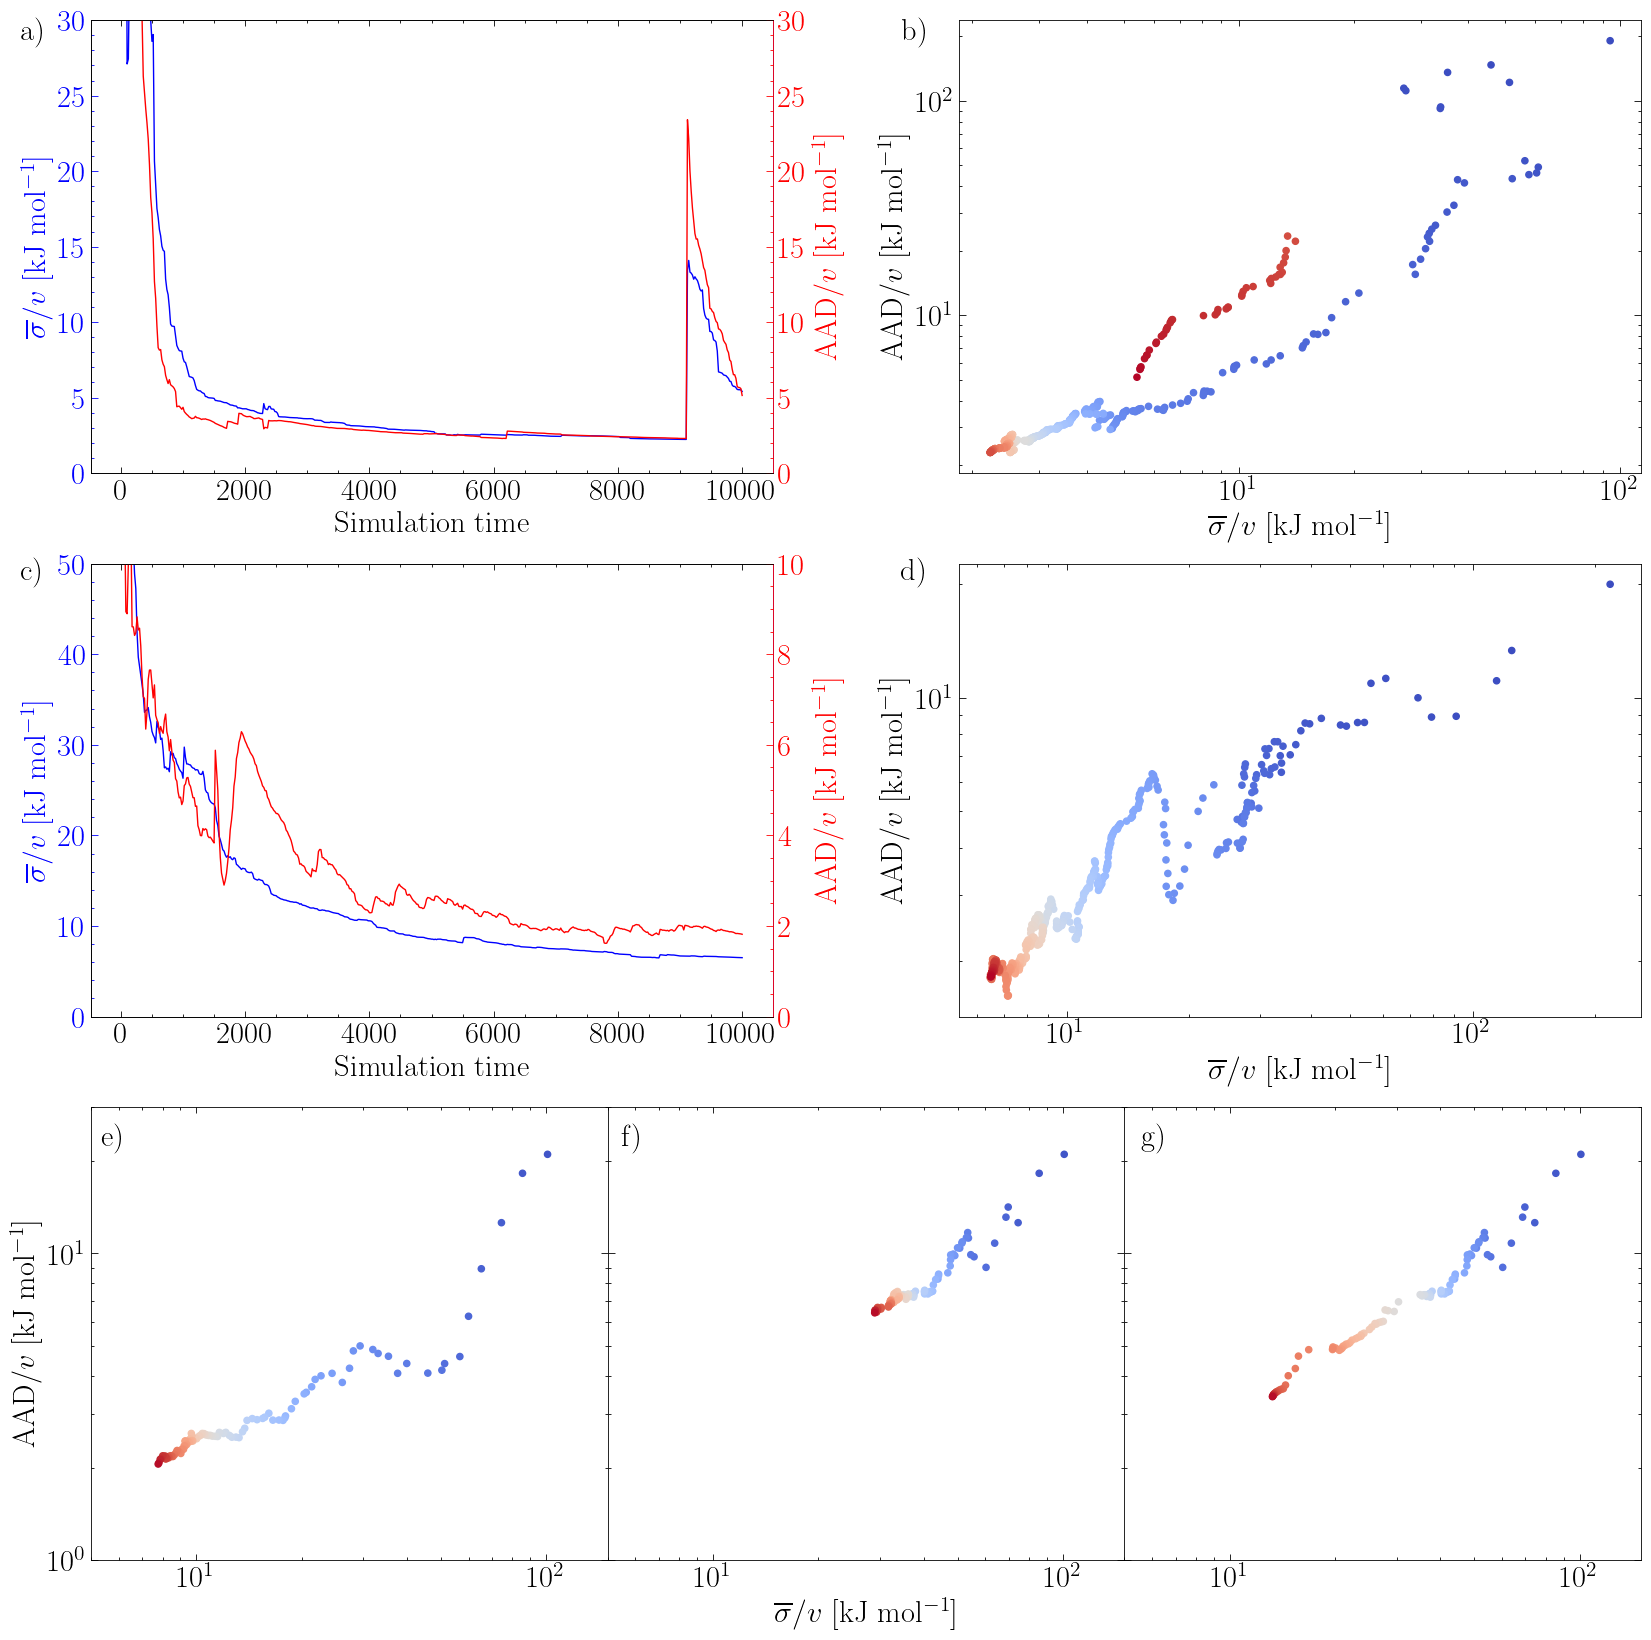

In [ ]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(3, 100, height_ratios=[1, 1, 1])

ax1 = fig.add_subplot(gs[0, :44])
ax2 = ax1.twinx()
ax3 = fig.add_subplot(gs[0, 56:])  
ax4 = fig.add_subplot(gs[1, :44]) 
ax5 = ax4.twinx() 
ax6 = fig.add_subplot(gs[1, 56:])  

gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1])

ax7 = fig.add_subplot(gs[2, 0]) 
ax8 = fig.add_subplot(gs[2, 1], sharex=ax7, sharey=ax7)  
ax9 = fig.add_subplot(gs[2, 2], sharex=ax8, sharey=ax8) 
##############################################################################################################
##############################################################################################################


ax1.plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1) ,color='blue',linewidth=1)
ax2.plot( time_history_1, np.asarray(aad_history_1) / np.asarray(volume_history_1) ,color='red',linewidth=1)
ax1.set_xlabel("Simulation time"); ax1.set_ylabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]", c="blue"); ax2.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 
ax1.set_ylim(0,30)
ax2.set_ylim(0,30)
# ax1.set_xlim(-750, 10200)
ax1.tick_params(axis='y', which='both', colors='blue'); ax1.spines['right'].set_color('blue')      
ax2.tick_params(axis='y', which='both', colors='red'); ax2.spines['right'].set_color('red')     

##############################################################################################################

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))

ax3.scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) ,s=20, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
ax3.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); ax3.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]"); ax3.set_xscale("log"); ax3.set_yscale("log")


##############################################################################################################
##############################################################################################################


ax4.plot( time_history_2, np.asarray(ofe_history_2) / np.asarray(volume_history_2) ,color='blue',linewidth=1,label="Aofe")
ax5.plot( time_history_2, np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,color='red',linewidth=1,label="AAD")
ax4.set_xlabel("Simulation time"); ax4.set_ylabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]", c="blue"); ax5.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")
ax4.set_ylim(0,50)
ax5.set_ylim(0,10)
# ax4.set_xlim(-750, 10200)
ax4.tick_params(axis='y', which='both', colors='blue'); ax4.spines['right'].set_color('blue')        
ax5.tick_params(axis='y', which='both', colors='red'); ax5.spines['right'].set_color('red')      

##############################################################################################################

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_2))

ax6.scatter(np.asarray(ofe_history_2) / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,s=20, c=range(len(ofe_history_2)), cmap=cmap, norm=norm)
ax6.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); ax6.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]"); ax6.set_xscale("log"); ax6.set_yscale("log")#;ax6.set_title("aad/v vs. ofe/v"); 


##############################################################################################################
##############################################################################################################
norm = plt.Normalize(0, len(ofe_history_31))

ax7.scatter(np.asarray(ofe_history_31) / np.asarray(volume_history_31), np.asarray(aad_history_31)[:,1] / np.asarray(volume_history_31) ,s=20, c=range(len(ofe_history_31)), cmap=cmap, norm=norm)
# ax7.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); 
ax7.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")
ax7.set_xscale("log"); ax7.set_yscale("log")
ax7.set_ylim(1, 30); ax7.set_xlim(5, 150)

##############################################################################################################


ax8.scatter(np.asarray(ofe_history_32)  / np.asarray(volume_history_32), np.asarray(aad_history_32)[:,1]  / np.asarray(volume_history_32) ,s=20, c=range(len(ofe_history_32)), cmap=cmap, norm=norm)
ax8.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); 
# ax8.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")
ax8.set_xscale("log"); ax8.set_yscale("log")
ax8.set_ylim(1, 30); ax8.set_xlim(5, 150)
plt.setp(ax8.get_yticklabels(), visible=False)

##############################################################################################################


ax9.scatter(np.asarray(ofe_history_33) / np.asarray(volume_history_33), np.asarray(aad_history_33)[:,1] / np.asarray(volume_history_33) ,s=20, c=range(len(ofe_history_33)), cmap=cmap, norm=norm)
# ax9.set_xlabel("$\overline{\sigma}/v$ [kJ mol$^{-1}$]"); 
# ax9.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]")
ax9.set_xscale("log"); ax9.set_yscale("log")
ax9.set_ylim(1, 30); ax9.set_xlim(5, 150)
plt.setp(ax9.get_yticklabels(), visible=False)


##############################################################################################################
##############################################################################################################

h = [0.87, 0.6, 0.317]
w = [0.09, 0.53]
w2 = [0.13, 0.39, 0.65]

fig.text(x=w[0], y=h[0], s="a)"); fig.text(x=w[1], y=h[0], s="b)")
fig.text(x=w[0], y=h[1], s="c)"); fig.text(x=w[1], y=h[1], s="d)")
fig.text(x=w2[0], y=h[2], s="e)"); fig.text(x=w2[1], y=h[2], s="f)"); fig.text(x=w2[2], y=h[2], s="g)")

plt.subplots_adjust(wspace=0)

plt.savefig(path_Figure_E + 'FigureE_2.png', dpi=600, bbox_inches='tight')

plt.show()

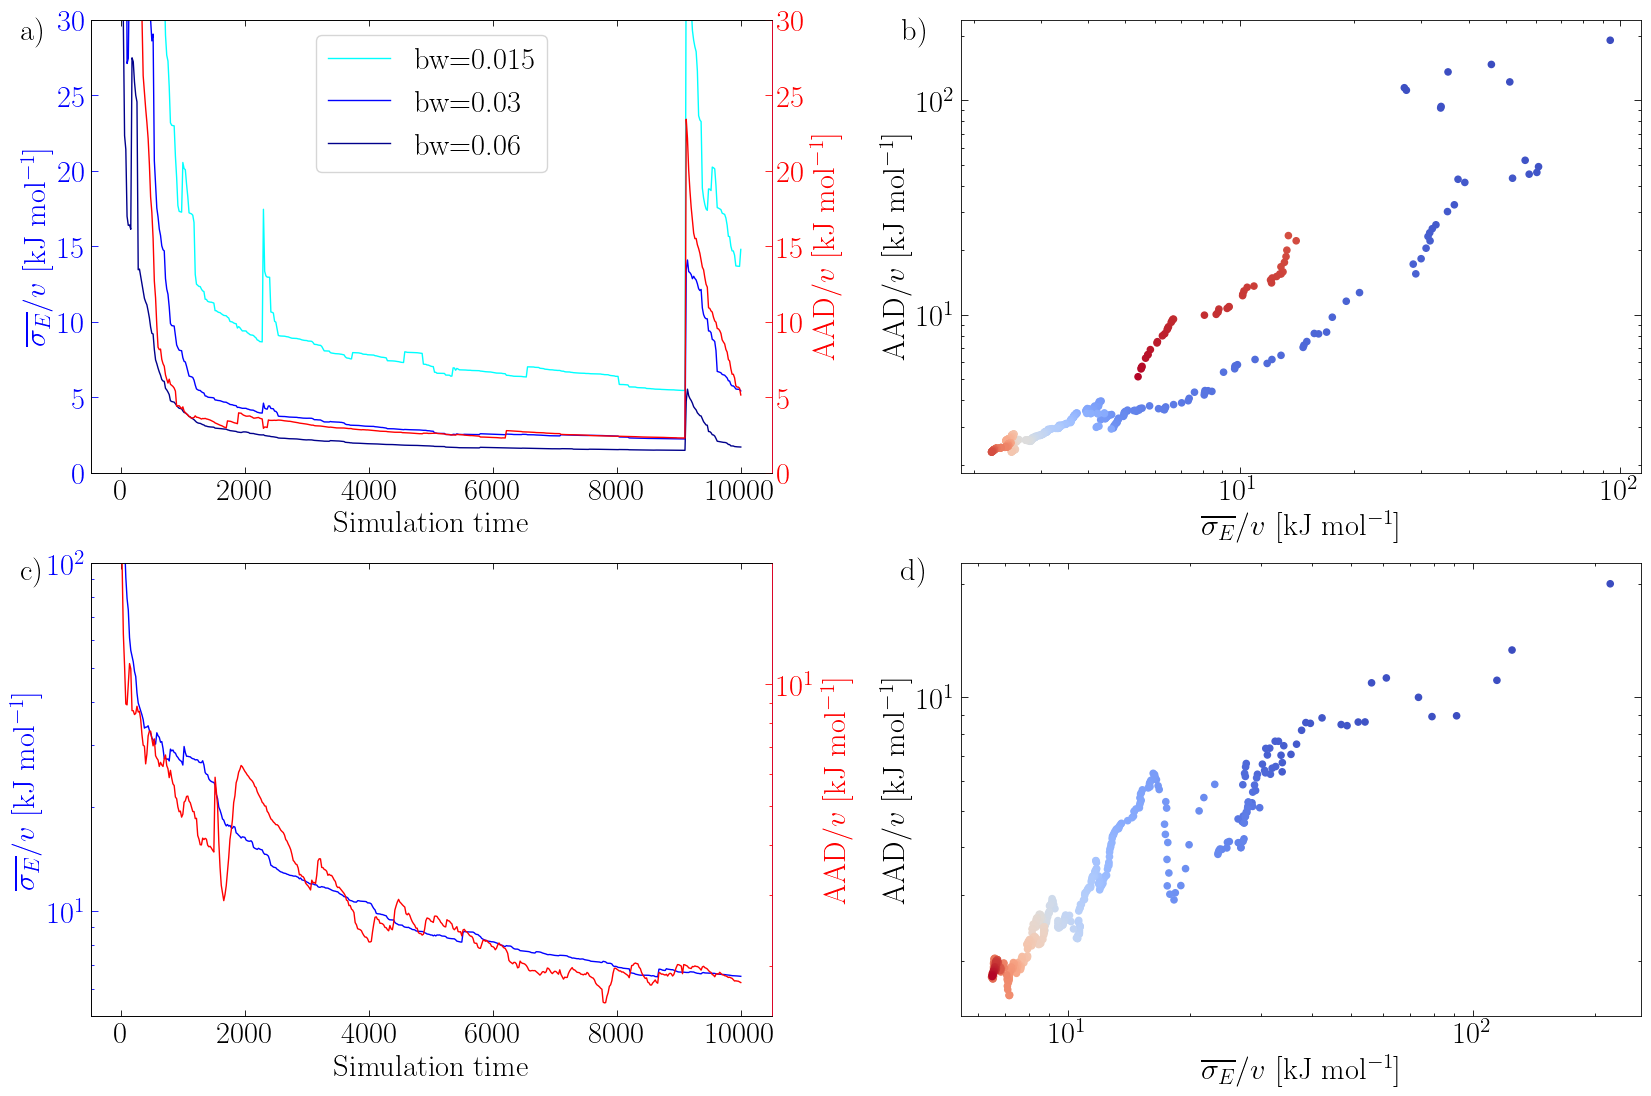

In [ ]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(3, 100, height_ratios=[1, 1, 1])

ax1 = fig.add_subplot(gs[0, :44])
ax2 = ax1.twinx()
ax3 = fig.add_subplot(gs[0, 56:])  
ax4 = fig.add_subplot(gs[1, :44]) 
ax5 = ax4.twinx() 
ax6 = fig.add_subplot(gs[1, 56:])  

##############################################################################################################

# ax1.plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1) ,color='blue',linewidth=1)

ax1.plot( time_history_11, np.asarray(ofe_history_11) / np.asarray(volume_history_11) ,color='cyan',linewidth=1    , label="bw=0.015")
ax1.plot( time_history_12, np.asarray(ofe_history_12) / np.asarray(volume_history_12) ,color='blue',linewidth=1    , label="bw=0.03")
ax1.plot( time_history_13, np.asarray(ofe_history_13) / np.asarray(volume_history_13) ,color='darkblue',linewidth=1, label="bw=0.06")

ax2.plot( time_history_1, np.asarray(aad_history_1) / np.asarray(volume_history_1) ,color='red',linewidth=1)
ax1.set_xlabel("Simulation time"); ax1.set_ylabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]", c="blue"); ax2.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 
ax1.set_ylim(0,30)
ax2.set_ylim(0,30)
# ax1.set_xlim(-750, 10200)
ax1.tick_params(axis='y', which='both', colors='blue'); ax1.spines['right'].set_color('blue')      
ax2.tick_params(axis='y', which='both', colors='red'); ax2.spines['right'].set_color('red')  

ax1.legend()   

##############################################################################################################

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))

ax3.scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1) / np.asarray(volume_history_1) ,s=20, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
ax3.set_xlabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]"); ax3.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]"); ax3.set_xscale("log"); ax3.set_yscale("log")

##############################################################################################################

ax4.plot( time_history_2, np.asarray(ofe_history_2) / np.asarray(volume_history_2) ,color='blue',linewidth=1,label="Aofe")
ax5.plot( time_history_2, np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,color='red',linewidth=1,label="AAD")
ax4.set_xlabel("Simulation time"); ax4.set_ylabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]", c="blue"); ax5.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]", c="red")
ax4.set_ylim(5,100)
ax5.set_ylim(1.5,20)
ax4.set_yscale("log")
ax5.set_yscale("log")

# ax4.set_xlim(-750, 10200)
ax4.tick_params(axis='y', which='both', colors='blue'); ax4.spines['right'].set_color('blue')        
ax5.tick_params(axis='y', which='both', colors='red'); ax5.spines['right'].set_color('red')      

##############################################################################################################

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_2))

ax6.scatter(np.asarray(ofe_history_2) / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,s=20, c=range(len(ofe_history_2)), cmap=cmap, norm=norm)
ax6.set_xlabel("$\overline{\sigma_E}/v$ [kJ mol$^{-1}$]"); ax6.set_ylabel("AAD/$v$ [kJ mol$^{-1}$]"); ax6.set_xscale("log"); ax6.set_yscale("log")#;ax6.set_title("aad/v vs. ofe/v"); 
##############################################################################################################


h = [0.87, 0.6, 0.317]
w = [0.09, 0.53]

fig.text(x=w[0], y=h[0], s="a)"); fig.text(x=w[1], y=h[0], s="b)")
fig.text(x=w[0], y=h[1], s="c)"); fig.text(x=w[1], y=h[1], s="d)")
plt.savefig(path_Figure_E + 'FigureE_new.png', dpi=200, bbox_inches='tight')
plt.show()